## DIAGNOSTIC PLOTS

Results get worse when I filter out rain flagged cells, probably because more rain flagged cells are present in an area 2-5 * Rmax, and my KXX models are better in this region than outside.

Current convention for inflow angle is: alpha = np.arctan(u / v) where v is positive even in the southern hemisphere! (same in ZU12)

Note that K25_PRM is worse than K01_PRM in terms of inflow angle!

Make sure the filters match.

For KXX_PRM models, I use the raw database based on the common filters (472 cases). For the KXX_FIT and KXX_wIA models, I use the cleaned databases (~100 cases). Maybe change that later. Maybe merge the analyze cases onto the cleaned database. In any case, I will have to do this for the wIA models issued from the list_of_collocated_paths list.

Note that the kernel dies after each subsection (e.g 1a). So for now just re-run the notebook section by section.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth':     '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir':     '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir':     '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/03_DIAGNOSE_PLOTS/',
    'sct_dir':     '/home/arthur/data/tropical_cyclones/scatterometer/hy-2/',
    'K01_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K01/cases/',
    'K01_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/cases/',
    'K01_wIA_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/cases/',
    'K25_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/cases/',
    'K25_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/cases/',
    'K25_wIA_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/cases/',
    'ZU12_dir':    '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_ZU12/cases/',
}

PRMS = {
    'dt':        90, # Delta time used for SAR/SCT collocation, in min
    'mask_rain': True,
    'sav_fgs':   True,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Fetch all PRM files
list_of_PRM_paths = glob.glob(PTHS['K01_PRM_dir'] + '*.nc')

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 10) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) &
    (dsg.dist2coast  > dsg.r34)              # Distance to coast
    # ((dsg.storm_speed_ibt / dsg.vws_pmd) > 1) # Ratio storm_speed / wind_shear
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

472


In [4]:
# ### OLD

# # FILTERS
# cond = (
#     (dsg.center_quality_flag < 2) & 
#     (dsg.percent_outside < 50) & 
#     (dsg.percent_rmx_inside == 1) &
#     (abs(dsg.lat) < 30) & 
#     (dsg.rmx < 100000) & 
#     (dsg.vmx > 20)
# )
# dsg_filtered    = dsg.where(cond, drop=True)
# print(len(dsg_filtered.time))

In [5]:
# # FILTERS
# cond = (
#     # (dsg.lat > 0) &             # Northern hemisphere; Remove this filter?
#     (dsg.dist2coast  > dsg.r34) & # Distance to coast
#     (dsg.percent_outside < 10)  & # Sufficient SAR coverage
#     (dsg.vmx > 20)    
# )
# dsg_filtered    = dsg.where(cond, drop=True)
# print(len(dsg_filtered.time))

In [6]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

### 0) Fitting diagnostic and datasets filtering

The retained filters are:

In [7]:
# dk01 = dkg01.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
#     (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
#     (dkg01.vmx > 20)                            & # Test
#     (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
#     (dkg01.C_K01 != 0.1)                        &  # Reached the upper bound
#     (dkg01.asym_avg_err  <= 3)                     # Asymmetry is fitted
#     # (~xr.where(dkg01.non_C1 == 0, False, True))  # Ensure that I > V/r
# )

# abs(dk01.C_sqrtK_K01 - dk012.C_sqrtK_K01) > 1e-5

With the subtility that dkg01.asym_avg_err <= 3 for K01 and dkg.asym_avg_err  <= 2 for K25 (explainable because the K01 asymmetries are less consistent with SAR than the K25 ones). Also, the non-C1 filter can be a posteriori highlighted on the plots. 

Lastly, we have to include the additional filter: abs(dk01.C_sqrtK_K01 - dk012.C_sqrtK_K01) > 1e-5 and same for K25, to make sure that I don't have any fitting issue (where dk01 is with fixed_K = 50 and dk012 is with fixed_K = 100).

#### a) K01_FIT

In [8]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto50.nc'
dkg01 = xr.open_dataset(p)
dk01  = dkg01.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
    (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01.vmx > 20)                            & # Test
    (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01.asym_avg_err  <= 3)                    # Asymmetry is fitted
    # (~xr.where(dkg01.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg01.max_asym_K01 > 1.1) | (dkg01.max_asym_sar < 2)) # Test
    # (dkg01.phase_avg_err <= 45)                 &           # Test
    # ((dkg01.storm_speed_ibt / dkg01.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01.time))
print(len(dk01.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
306


In [9]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto100.nc'
dkg01_withKsetto100 = xr.open_dataset(p)
dk01_withKsetto100  = dkg01_withKsetto100.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01_withKsetto100.dist2coast  > dkg01_withKsetto100.r34)             & # Distance to coast
    (dkg01_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg01_withKsetto100.vmx > 20)                                          & # Test
    (dkg01_withKsetto100.C_K01 != 0.0001)                                   & # Reached the lower bound
    (dkg01_withKsetto100.C_K01 != 0.1)                                      & # Reached the upper bound
    (dkg01_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg01_withKsetto100.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg01_withKsetto100.max_asym_K01 > 1.1) | (dkg01_withKsetto100.max_asym_sar <2)) # Test
    # (dkg01_withKsetto100.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01_withKsetto100.storm_speed_ibt / dkg01_withKsetto100.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01_withKsetto100.time))
print(len(dkg01_withKsetto100.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
472


In [10]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto10.nc'
dkg01_withKsetto10 = xr.open_dataset(p)
dk01_withKsetto10  = dkg01_withKsetto10.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01_withKsetto10.dist2coast  > dkg01_withKsetto10.r34)             & # Distance to coast
    (dkg01_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg01_withKsetto10.vmx > 20)                                          & # Test
    (dkg01_withKsetto10.C_K01 != 0.0001)                                   & # Reached the lower bound
    (dkg01_withKsetto10.C_K01 != 0.1)                                      & # Reached the upper bound
    (dkg01_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg01_withKsetto10.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg01_withKsetto10.max_asym_K01 > 1.1) | (dkg01_withKsetto10.max_asym_sar <2)) # Test
    # (dkg01_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01_withKsetto10.storm_speed_ibt / dkg01_withKsetto10.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01_withKsetto10.time))
print(len(dkg01_withKsetto10.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
472


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

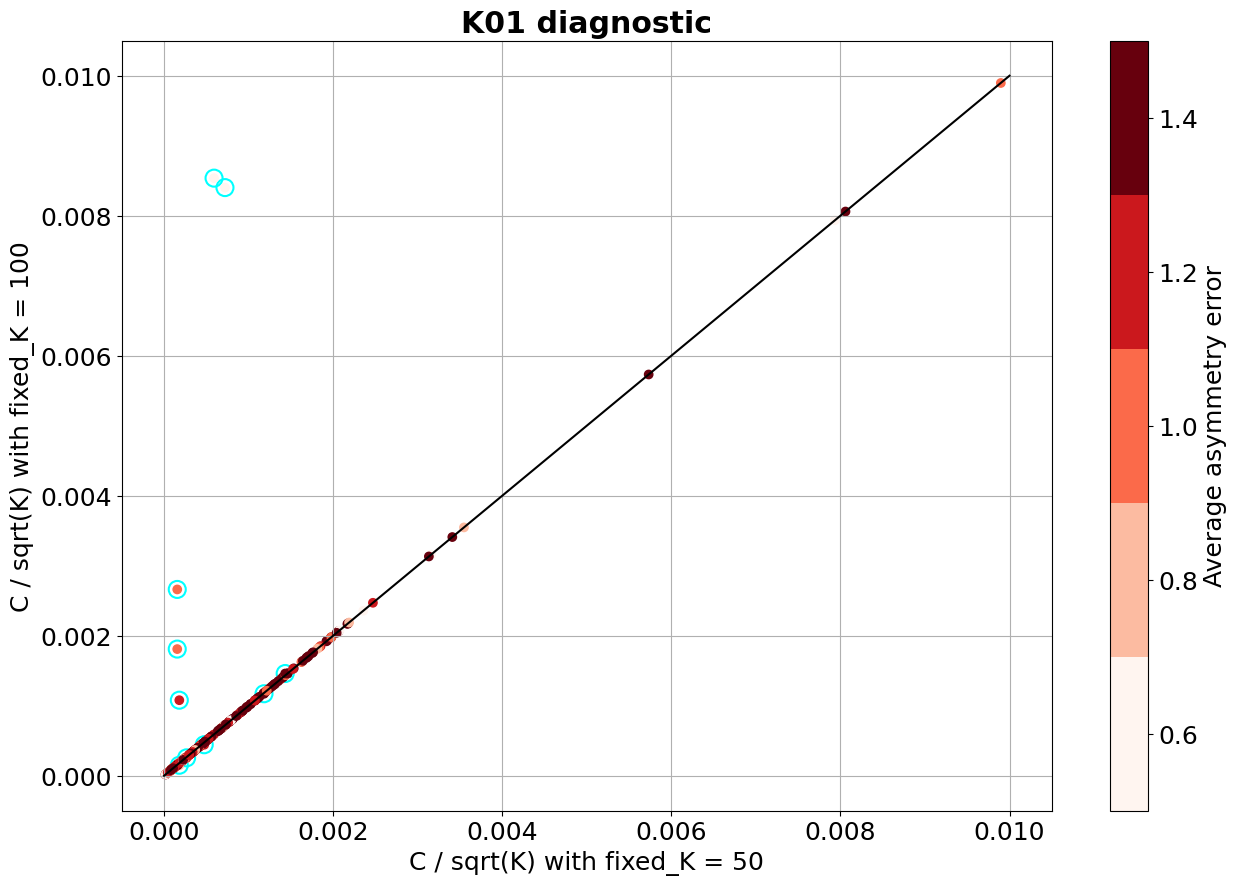

In [11]:
plt.title('K01 diagnostic', weight='bold')
msk_k01_upper = (abs(dk01.C_sqrtK_K01 - dk01_withKsetto100.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01.where(msk_k01_upper).C_sqrtK_K01, dk01_withKsetto100.where(msk_k01_upper).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01.C_sqrtK_K01, dk01_withKsetto100.C_sqrtK_K01, c=dk01.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

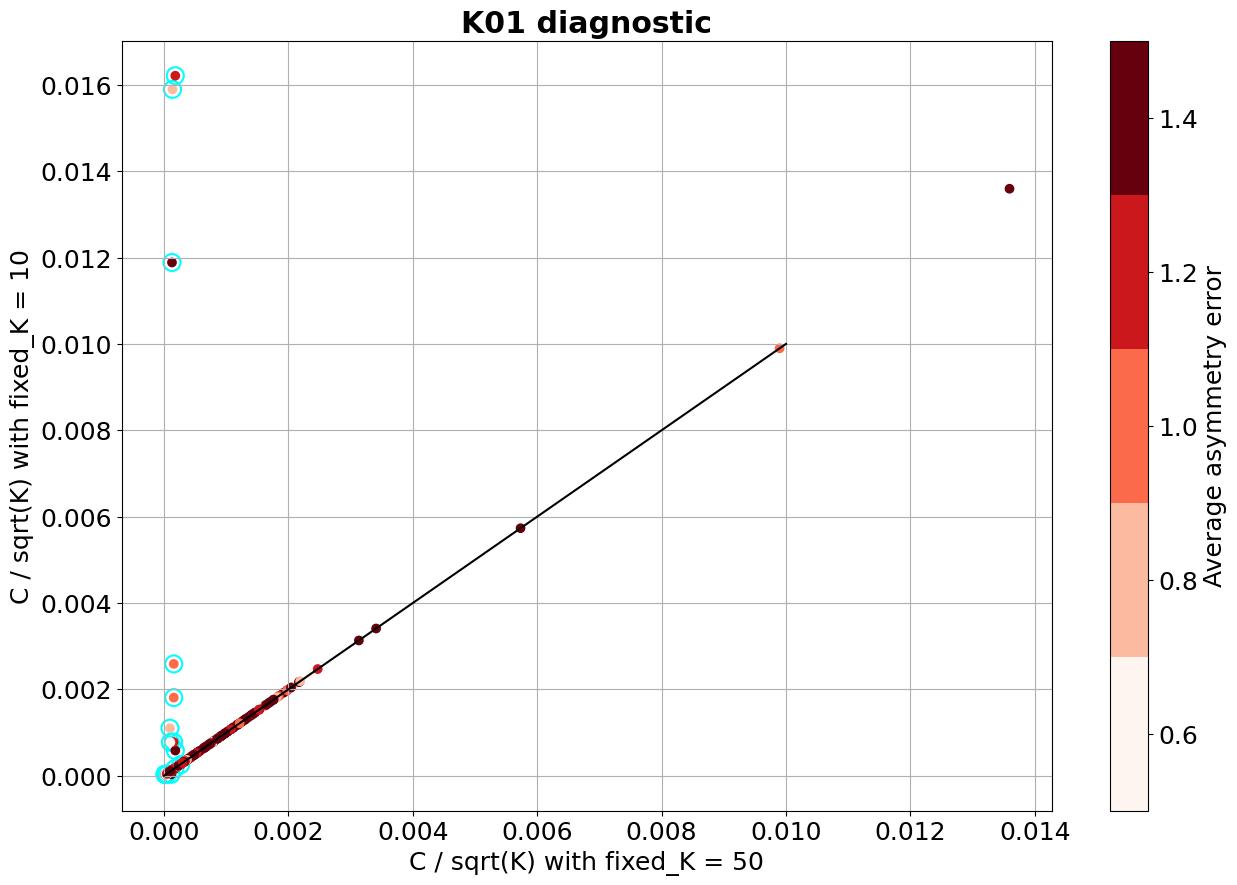

In [12]:
plt.title('K01 diagnostic', weight='bold')
msk_k01_lower = (abs(dk01.C_sqrtK_K01 - dk01_withKsetto10.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01.where(msk_k01_lower).C_sqrtK_K01, dk01_withKsetto10.where(msk_k01_lower).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01.C_sqrtK_K01, dk01_withKsetto10.C_sqrtK_K01, c=dk01.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

For ~30-50 cases, the fitting bounds for C are reached (see commented cell below). They correspond to complicated cases.

In [13]:
# a  = dkg01_withKsetto10.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01_withKsetto10.dist2coast  > dkg01_withKsetto10.r34)             & # Distance to coast
#     (dkg01_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg01_withKsetto10.C_K01 != 0.0001)                                   & # Reached the lower bound
#     # (dkg01_withKsetto10.C_K01 != 0.1)                                      & # Reached the upper bound
#     (dkg01_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(a.where(a.C_K01 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K01 < 0.00010001, drop=True).time))

# b  = dkg01_withKsetto100.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01_withKsetto100.dist2coast  > dkg01_withKsetto100.r34)             & # Distance to coast
#     (dkg01_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg01_withKsetto100.C_K01 != 0.0001)                                   & # Reached the lower bound
#     # (dkg01_withKsetto100.C_K01 != 0.1)                                      & # Reached the upper bound
#     (dkg01_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(b.where(b.C_K01 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K01 < 0.00010001, drop=True).time))

#### b) K25_FIT

In [14]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto50.nc'
dkg25 = xr.open_dataset(p)
dk25  = dkg25.where(
    # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25.dist2coast  > dkg25.r34)             & # Distance to coast
    (dkg25.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg25.vmx > 20)                            & # Test
    (dkg25.C_K25 != 0.0001)                     & # Reached the lower bound
    (dkg25.C_K25 != 0.1)                        & # Reached the upper bound
    (dkg25.asym_avg_err  <= 2)                    # Asymmetry is fitted
    # (~xr.where(dkg25.non_C1 == 0, False, True)) # Ensure that I > V/r

    # ((dkg25.max_asym_K25 > 1.1) | (dkg25.max_asym_sar < 2)) # Test
    # (dkg25.phase_avg_err <= 45)                           & # Test
    # (dkg25.C_sqrtK_K25 > 1.5e-5)                          & # Test: Reached the lower bound
    # (dkg25.C_sqrtK_K25 < 1.41e-3)                         & # Test: Reached the upper bound
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25.time))
print(len(dk25.dropna(dim='time', subset=['vmx']).time))

472
362


In [15]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto100.nc'
dkg25_withKsetto100 = xr.open_dataset(p)
dk25_withKsetto100  = dkg25_withKsetto100.where(
    # (dkg25_withKsetto100.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_withKsetto100.dist2coast  > dkg25_withKsetto100.r34)             & # Distance to coast
    (dkg25_withKsetto100.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg25_withKsetto100.vmx > 20)                          & # Test
    (dkg25_withKsetto100.C_K25 != 0.0001)                   & # Reached the lower bound
    (dkg25_withKsetto100.C_K25 != 0.1)                      & # Reached the upper bound
    (dkg25_withKsetto100.asym_avg_err  <= 2)                 # Asymmetry is fitted
    # (~xr.where(dkg25_withKsetto100.non_C1 == 0, False, True)) # Ensure that I > V/r

    # ((dkg25_withKsetto100.max_asym_K25 > 1.1) | (dkg25_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg25_withKsetto100.phase_avg_err <= 45)                                         & # Test
    # (dkg25_withKsetto100.C_sqrtK_K25 > 1.5e-5)                                        & # Test: Reached the lower bound
    # (dkg25_withKsetto100.C_sqrtK_K25 < 1.41e-3)                                       & # Test: Reached the upper bound    
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25_withKsetto100.time))
print(len(dk25_withKsetto100.dropna(dim='time', subset=['vmx']).time))

472
373


In [16]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto10.nc'
dkg25_withKsetto10 = xr.open_dataset(p)
dk25_withKsetto10  = dkg25_withKsetto10.where(
    # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_withKsetto10.dist2coast  > dkg25_withKsetto10.r34)              & # Distance to coast
    (dkg25_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg25_withKsetto10.vmx > 20)                                          & # Test
    (dkg25_withKsetto10.C_K25 != 0.0001)                                   & # Reached the lower bound
    (dkg25_withKsetto10.C_K25 != 0.1)                                      & # Reached the upper bound
    (dkg25_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg25_withKsetto10.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg25_withKsetto10.max_asym_K25 > 1.1) | (dkg25_withKsetto10.max_asym_sar <2)) # Test
    # (dkg25_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg25_withKsetto10.storm_speed_ibt / dkg25_withKsetto10.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25_withKsetto10.time))
print(len(dkg25_withKsetto10.dropna(dim='time', subset=['vmx']).time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

472
472


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

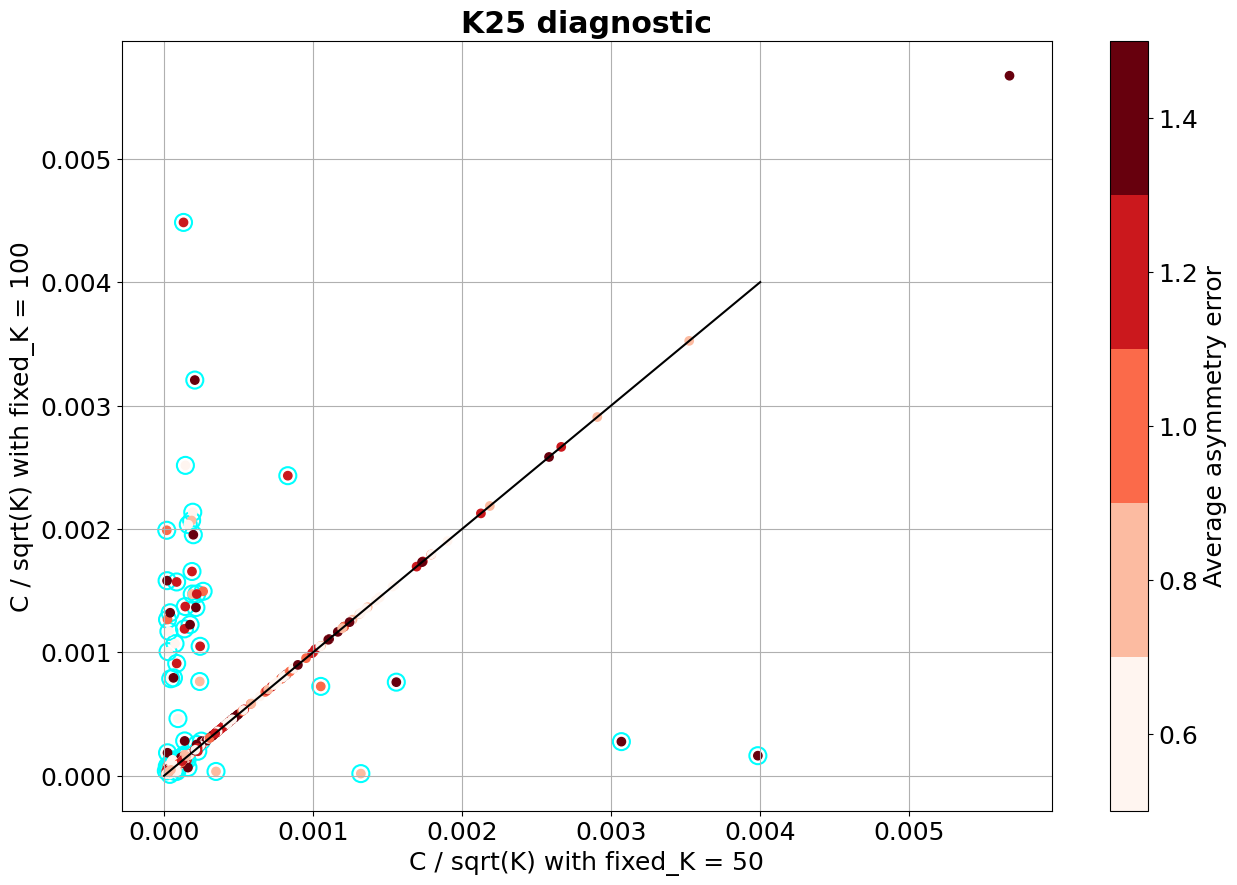

In [17]:
plt.title('K25 diagnostic', weight='bold')
msk_k25_upper = (abs(dk25.C_sqrtK_K25 - dk25_withKsetto100.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25.where(msk_k25_upper).C_sqrtK_K25, dk25_withKsetto100.where(msk_k25_upper).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25.C_sqrtK_K25, dk25_withKsetto100.C_sqrtK_K25, c=dk25.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.004], [0, 0.004], c='k')
# plt.xlim(0, 0.003)
# plt.ylim(0, 0.003)
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

In [18]:
plt.title('K25 diagnostic', weight='bold')
msk_k25_lower = (abs(dk25.C_sqrtK_K25 - dk25_withKsetto10.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25.where(msk_k25_lower).C_sqrtK_K25, dk25_withKsetto10.where(msk_k25_lower).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25.C_sqrtK_K25, dk25_withKsetto10.C_sqrtK_K25, c=dk25.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.004], [0, 0.004], c='k')
# plt.xlim(0, 0.003)
# plt.ylim(0, 0.003)
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

Error in callback <function _draw_all_if_interactive at 0x7e5fbecb8d60> (for post_execute), with arguments args (),kwargs {}:
Error in callback <function flush_figures at 0x7e5fbb728e00> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt


KeyboardInterrupt



The fitting bounds for C are not reached (see commented cell below).

In [19]:
# a  = dkg25_withKsetto10.where(
#     # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25_withKsetto10.dist2coast  > dkg25_withKsetto10.r34)             & # Distance to coast
#     (dkg25_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg25_withKsetto10.C_K25 != 0.0001)                                   & # Reached the lower bound
#     # (dkg25_withKsetto10.C_K25 != 0.1)                                      & # Reached the upper bound
#     (dkg25_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(a.where(a.C_K25 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K25 < 0.00010001, drop=True).time))

# b  = dkg25_withKsetto100.where(
#     # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25_withKsetto100.dist2coast  > dkg25_withKsetto100.r34)             & # Distance to coast
#     (dkg25_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg25_withKsetto100.C_K25 != 0.0001)                                   & # Reached the lower bound
#     # (dkg25_withKsetto100.C_K25 != 0.1)                                      & # Reached the upper bound
#     (dkg25_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(b.where(b.C_K25 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K25 < 0.00010001, drop=True).time))

#### c) K25_semiFit

In [20]:
### K25 SemiFit
p             = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/dsg_K25_semiFit.nc'
dkg25_semiFit = xr.open_dataset(p)
dk25_semiFit  = dkg25_semiFit.where(
    # (dkg25_semiFit.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_semiFit.dist2coast  > dkg25_semiFit.r34)     & # Distance to coast
    (dkg25_semiFit.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg25_semiFit.vmx > 20)                          & # Test
    (dkg25_semiFit.asym_avg_err  <= 2)                 # Asymmetry is fitted
    # (~xr.where(dkg25_semiFit.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # (dkg25_semiFit.phase_avg_err <= 45)               & # Test
    # (dkg25_semiFit.C_sqrtK_K25 > 1.5e-5)              & # Test: Reached the lower bound
    # (dkg25_semiFit.C_sqrtK_K25 < 1.41e-3)             & # Test: Reached the upper bound
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25_semiFit.time))
print(len(dk25_semiFit.dropna(dim='time', subset=['vmx']).time))


KeyboardInterrupt



#### d) K01_wIA

In [ ]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto50.nc'
dkg01i = xr.open_dataset(p)
dk01i  = dkg01i.where(
    # (dkg01.lat > 0) &                            # Northern hemisphere; Remove this filter?
    (dkg01i.dist2coast  > dkg01i.r34)            & # Distance to coast
    (dkg01i.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01i.vmx > 20)                            & # Test
    (dkg01i.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01i.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01i.asym_avg_err  <= 3)                  & # Asymmetry is fitted
    (dkg01i.ratio_of_valid_scat_values > 0.9)      # Sufficient Scat coverage
    # (~xr.where(dkg01i.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg01i.max_asym_K01 > 1.1) | (dkg01.max_asym_sar < 2)) # Test
    # (dkg01i.phase_avg_err <= 45)                 &           # Test
    # ((dkg01i.storm_speed_ibt / dkg01.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i.time))
print(len(dk01i.dropna(dim='time', subset=['vmx']).time))

In [ ]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto100.nc'
dkg01i_withKsetto100 = xr.open_dataset(p)
dk01i_withKsetto100  = dkg01i_withKsetto100.where(
    # (dkg01_withKsetto100.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg01i_withKsetto100.dist2coast  > dkg01i_withKsetto100.r34)             & # Distance to coast
    (dkg01i_withKsetto100.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg01i_withKsetto100.vmx > 20)                                           & # Test
    (dkg01i_withKsetto100.C_K01 != 0.0001)                                    & # Reached the lower bound
    (dkg01i_withKsetto100.C_K01 != 0.1)                                       & # Reached the upper bound
    (dkg01i_withKsetto100.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                     # Sufficient Scat coverage
    # (~xr.where(dkg01i_withKsetto100.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg01i_withKsetto100.max_asym_K01 > 1.1) | (dkg01_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg01i_withKsetto100.phase_avg_err <= 45)                 &                         # Test
    # ((dkg01i_withKsetto100.storm_speed_ibt / dkg01_withKsetto100.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i_withKsetto100.time))
print(len(dk01i_withKsetto100.dropna(dim='time', subset=['vmx']).time))

In [ ]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto10.nc'
dkg01i_withKsetto10 = xr.open_dataset(p)
dk01i_withKsetto10  = dkg01i_withKsetto10.where(
    # (dkg01_withKsetto10.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg01i_withKsetto10.dist2coast  > dkg01i_withKsetto10.r34)              & # Distance to coast
    (dkg01i_withKsetto10.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg01i_withKsetto10.vmx > 20)                                           & # Test
    (dkg01i_withKsetto10.C_K01 != 0.0001)                                    & # Reached the lower bound
    (dkg01i_withKsetto10.C_K01 != 0.1)                                       & # Reached the upper bound
    (dkg01i_withKsetto10.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
    # (~xr.where(dkg01i_withKsetto10.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg01i_withKsetto10.max_asym_K01 > 1.1) | (dkg01_withKsetto10.max_asym_sar < 2)) # Test
    # (dkg01i_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01i_withKsetto10.storm_speed_ibt / dkg01_withKsetto10.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i_withKsetto10.time))
print(len(dk01i_withKsetto10.dropna(dim='time', subset=['vmx']).time))

In [ ]:
plt.title('K01_wIA diagnostic', weight='bold')
msk_k01i_upper = (abs(dk01i.C_sqrtK_K01 - dk01i_withKsetto100.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01i.where(msk_k01i_upper).C_sqrtK_K01, dk01i_withKsetto100.where(msk_k01i_upper).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01i.C_sqrtK_K01, dk01i_withKsetto100.C_sqrtK_K01, c=dk01i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

In [ ]:
plt.title('K01_wIA diagnostic', weight='bold')
msk_k01i_lower = (abs(dk01i.C_sqrtK_K01 - dk01i_withKsetto10.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01i.where(msk_k01i_lower).C_sqrtK_K01, dk01i_withKsetto10.where(msk_k01i_lower).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01i.C_sqrtK_K01, dk01i_withKsetto10.C_sqrtK_K01, c=dk01i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

The fitting bounds for C are only reached for 2 cases (see commented cell below).

In [ ]:
# a  = dkg01i_withKsetto10.where(
#     # (dkg01i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01i_withKsetto10.dist2coast  > dkg01i_withKsetto10.r34)             & # Distance to coast
#     (dkg01i_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01i_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg01i_withKsetto10.C_K01 != 0.0001)                                 & # Reached the lower bound
#     # (dkg01i_withKsetto10.C_K01 != 0.1)                                    & # Reached the upper bound
#     (dkg01i_withKsetto10.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                   # Sufficient Scat coverage
# )
# print(len(a.where(a.C_K01 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K01 < 0.00010001, drop=True).time))

# b  = dkg01i_withKsetto100.where(
#     # (dkg01i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01i_withKsetto100.dist2coast  > dkg01i_withKsetto100.r34)            & # Distance to coast
#     (dkg01i_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01i_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg01i_withKsetto100.C_K01 != 0.0001)                                 & # Reached the lower bound
#     # (dkg01i_withKsetto100.C_K01 != 0.1)                                    & # Reached the upper bound
#     (dkg01i_withKsetto100.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
# )
# print(len(b.where(b.C_K01 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K01 < 0.00010001, drop=True).time))

#### e) K25_wIA

In [ ]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto50.nc'
dkg25i = xr.open_dataset(p)
dk25i  = dkg25i.where(
    # (dkg25.lat > 0) &                            # Northern hemisphere; Remove this filter?
    (dkg25i.dist2coast  > dkg25i.r34)            & # Distance to coast
    (dkg25i.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg25i.vmx > 20)                            & # Test
    (dkg25i.C_K25 != 0.0001)                     & # Reached the lower bound
    (dkg25i.C_K25 != 0.1)                        & # Reached the upper bound
    (dkg25i.asym_avg_err  <= 3)                  & # Asymmetry is fitted
    (dkg25i.ratio_of_valid_scat_values > 0.9)      # Sufficient Scat coverage
    # (~xr.where(dkg25i.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg25i.max_asym_K25 > 1.1) | (dkg25.max_asym_sar < 2)) # Test
    # (dkg25i.phase_avg_err <= 45)                 &           # Test
    # ((dkg25i.storm_speed_ibt / dkg25.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i.time))
print(len(dk25i.dropna(dim='time', subset=['vmx']).time))

In [ ]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto100.nc'
dkg25i_withKsetto100 = xr.open_dataset(p)
dk25i_withKsetto100  = dkg25i_withKsetto100.where(
    # (dkg25_withKsetto100.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg25i_withKsetto100.dist2coast  > dkg25i_withKsetto100.r34)             & # Distance to coast
    (dkg25i_withKsetto100.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg25i_withKsetto100.vmx > 20)                                           & # Test
    (dkg25i_withKsetto100.C_K25 != 0.0001)                                    & # Reached the lower bound
    (dkg25i_withKsetto100.C_K25 != 0.1)                                       & # Reached the upper bound
    (dkg25i_withKsetto100.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                     # Sufficient Scat coverage
    # (~xr.where(dkg25i_withKsetto100.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg25i_withKsetto100.max_asym_K25 > 1.1) | (dkg25_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg25i_withKsetto100.phase_avg_err <= 45)                 &                         # Test
    # ((dkg25i_withKsetto100.storm_speed_ibt / dkg25_withKsetto100.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i_withKsetto100.time))
print(len(dk25i_withKsetto100.dropna(dim='time', subset=['vmx']).time))

In [ ]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto10.nc'
dkg25i_withKsetto10 = xr.open_dataset(p)
dk25i_withKsetto10  = dkg25i_withKsetto10.where(
    # (dkg25_withKsetto10.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg25i_withKsetto10.dist2coast  > dkg25i_withKsetto10.r34)              & # Distance to coast
    (dkg25i_withKsetto10.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg25i_withKsetto10.vmx > 20)                                           & # Test
    (dkg25i_withKsetto10.C_K25 != 0.0001)                                    & # Reached the lower bound
    (dkg25i_withKsetto10.C_K25 != 0.1)                                       & # Reached the upper bound
    (dkg25i_withKsetto10.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
    # (~xr.where(dkg25i_withKsetto10.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg25i_withKsetto10.max_asym_K25 > 1.1) | (dkg25_withKsetto10.max_asym_sar < 2)) # Test
    # (dkg25i_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg25i_withKsetto10.storm_speed_ibt / dkg25_withKsetto10.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i_withKsetto10.time))
print(len(dk25i_withKsetto10.dropna(dim='time', subset=['vmx']).time))

In [ ]:
plt.title('K25_wIA diagnostic', weight='bold')
msk_k25i_upper = (abs(dk25i.C_sqrtK_K25 - dk25i_withKsetto100.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25i.where(msk_k25i_upper).C_sqrtK_K25, dk25i_withKsetto100.where(msk_k25i_upper).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25i.C_sqrtK_K25, dk25i_withKsetto100.C_sqrtK_K25, c=dk25i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

In [ ]:
plt.title('K25_wIA diagnostic', weight='bold')
msk_k25i_lower = (abs(dk25i.C_sqrtK_K25 - dk25i_withKsetto10.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25i.where(msk_k25i_lower).C_sqrtK_K25, dk25i_withKsetto10.where(msk_k25i_lower).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25i.C_sqrtK_K25, dk25i_withKsetto10.C_sqrtK_K25, c=dk25i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

The fitting bounds for C are only reached for 1 case (see commented cell below).

In [ ]:
# a  = dkg25i_withKsetto10.where(
#     # (dkg25i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25i_withKsetto10.dist2coast  > dkg25i_withKsetto10.r34)             & # Distance to coast
#     (dkg25i_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25i_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg25i_withKsetto10.C_K25 != 0.0001)                                 & # Reached the lower bound
#     # (dkg25i_withKsetto10.C_K25 != 0.1)                                    & # Reached the upper bound
#     (dkg25i_withKsetto10.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                   # Sufficient Scat coverage
# )
# print(len(a.where(a.C_K25 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K25 < 0.00010001, drop=True).time))

# b  = dkg25i_withKsetto100.where(
#     # (dkg25i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25i_withKsetto100.dist2coast  > dkg25i_withKsetto100.r34)            & # Distance to coast
#     (dkg25i_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25i_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg25i_withKsetto100.C_K25 != 0.0001)                                 & # Reached the lower bound
#     # (dkg25i_withKsetto100.C_K25 != 0.1)                                    & # Reached the upper bound
#     (dkg25i_withKsetto100.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
# )
# print(len(b.where(b.C_K25 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K25 < 0.00010001, drop=True).time))

#### f) Clean the datasets

In [ ]:
### FILTER BOTH DATASETS
# TO ENSURE THAT FIXED_K HAS NO IMPACT
dk01_clean  = dk01.where(~msk_k01_upper & ~msk_k01_lower)
dk25_clean  = dk25.where(~msk_k25_upper & ~msk_k25_lower)
dk01i_clean = dk01i.where(~msk_k01i_upper & ~msk_k01i_lower)
dk25i_clean = dk25i.where(~msk_k25i_upper & ~msk_k25i_lower)

# # TO DROP DUPLICATES FOR MULTIPLE SCAT COLLOCATIONS
# dk01i_clean = dk01i_clean.where(~dk01i_clean.indexes['time'].duplicated()).dropna(dim='time')
# dk25i_clean = dk25i_clean.where(~dk25i_clean.indexes['time'].duplicated()).dropna(dim='time')
dk01i_clean =  dk01i_clean.drop_duplicates(dim='time', keep='first')
dk25i_clean =  dk25i_clean.drop_duplicates(dim='time', keep='first')

### 1) Diagnose winds vs SAR and SCAT

We first extract necessary wind speeds and inflow angles.

Let us start with the wind speeds.

In [ ]:
### Define r_star
r_star = np.linspace(0, 16, 16 * 8 + 1)
# rs            = np.linspace(1000, 5e5, 500)

In [ ]:
# --- Création de la colormap personnalisée ---
colors = ["white",
          "saddlebrown",
          "lightgoldenrodyellow",
          "lightgreen",
          "darkgreen",
          "darkblue"]

nodes = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", list(zip(nodes, colors)))

In [ ]:
### Choose colors
# c_sar = '#1E5631'  # Dark Green
c_sar = 'darkgreen'
c_k01 = '#D62728'  # Brick Red
# c_k25 = '#1F77B4'  # Muted Blue
c_k25 = 'gold'
# c_sct = '#FF7F0E'  # Safety Orange
c_sct = 'sienna'
c_hol = '#9467BD'  # Deep Purple
# c_tbl = '#17BECF'   # Dark Cyan
# c_tbl = 'gold'
c_tbl = '#1F77B4'  # Muted Blue

#### a) KXX_PRM

In [39]:
### Extract SAR and KXX_PRM wind speed differences and interpolate them on r_star
# (about 2 minutes)

### Initialize
listOfWspds_dsp       = [] # SAR
# K01 param
listOfWspds_dsk01_prm = [] # K01 param
wspd_diffs_k01p       = [] # Wind speed diffs,                       
wspd_res_k01p         = [] # Wind speed relative errors
wspd_diffs_k01p_      = [] # Wind speed diffs, interp. on r_star                      
wspd_res_k01p_        = [] # Wind speed relative errors, interp. on r_star 
# K25 param
listOfWspds_dsk25_prm = [] # K25 param
wspd_diffs_k25p       = [] # Wind speed diffs,                       
wspd_res_k25p         = [] # Wind speed relative errors
wspd_diffs_k25p_      = [] # Wind speed diffs, interp. on r_star                       
wspd_res_k25p_        = [] # Wind speed relative errors, interp. on r_star

for path in tqdm(list_of_PRM_paths):
    dsk01_prm         = xr.open_dataset(PTHS['K01_PRM_dir'] + os.path.basename(path)).sel(z=10, theta=slice(0, 359))
    dsk25_prm         = xr.open_dataset(PTHS['K25_PRM_dir'] + os.path.basename(path)).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_prm.file_tcva.item(), drop=True).isel(time=0)
    dsp               = xr.open_dataset(PTHS['sar_dir'] + dsk01_prm.file_tcva.item()).isel(time=0)

    # Add the non-interpolated wind speeds
    wspd_diff_k01p    = np.subtract(np.array(dsp.wind_speed.transpose()), np.array(dsk01_prm.wind_speed))
    wspd_re_k01p      = np.divide(wspd_diff_k01p, np.array(dsp.wind_speed.transpose()))
    wspd_diff_k25p    = np.subtract(np.array(dsp.wind_speed.transpose()), np.array(dsk25_prm.wind_speed))
    wspd_re_k25p      = np.divide(wspd_diff_k25p, np.array(dsp.wind_speed.transpose()))

    # Interpolate on r_star
    dss, dk01p, dk25p = dsp.copy(deep=True), dsk01_prm.copy(deep=True), dsk25_prm.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk01p['rad']      = dk01p['rad'] / float(ds.rmx)
    dk25p['rad']      = dk25p['rad'] / float(ds.rmx)
    wspd_diff_k01p_   = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk01p.wind_speed.interp(rad=r_star)))
    wspd_re_k01p_     = np.divide(wspd_diff_k01p_, np.array(dss.wind_speed.transpose().interp(rad=r_star)))
    wspd_diff_k25p_   = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk25p.wind_speed.interp(rad=r_star)))
    wspd_re_k25p_     = np.divide(wspd_diff_k25p_, np.array(dss.wind_speed.transpose().interp(rad=r_star)))

    ### Append
    # SAR
    listOfWspds_dsp.append(np.array(dsp.wind_speed.transpose()).flatten())
    # K01 param
    listOfWspds_dsk01_prm.append(np.array(dsk01_prm.wind_speed).flatten())
    wspd_diffs_k01p.append(wspd_diff_k01p)
    wspd_res_k01p.append(wspd_re_k01p)
    wspd_diffs_k01p_.append(wspd_diff_k01p_)
    wspd_res_k01p_.append(wspd_re_k01p_)
    # K25 param
    listOfWspds_dsk25_prm.append(np.array(dsk25_prm.wind_speed).flatten())
    wspd_diffs_k25p.append(wspd_diff_k25p)
    wspd_res_k25p.append(wspd_re_k25p)
    wspd_diffs_k25p_.append(wspd_diff_k25p_)
    wspd_res_k25p_.append(wspd_re_k25p_)

    # Close
    dsp.close()
    dsk01_prm.close()
    dsk25_prm.close()
    dss.close()
    dk01p.close()
    dk25p.close()

  0%|          | 0/472 [00:00<?, ?it/s]

In [40]:
### Concatenate the raw wind speeds
wspds_dsp           = np.concatenate(listOfWspds_dsp)
wspds_dsk01_prm     = np.concatenate(listOfWspds_dsk01_prm)
wspds_dsk25_prm     = np.concatenate(listOfWspds_dsk25_prm)

### Concatenate the r_star wind speeds
arr_spd_diffs_k01p_ = np.concatenate(wspd_diffs_k01p_)
arr_spd_diffs_k25p_ = np.concatenate(wspd_diffs_k25p_)

We then extract the inflow angles.

In [41]:
### Open inflow angles
# (about 30 seconds)

# For debug, use t = 90

# Initialize
list_of_collocated_sct_pths = []
list_of_collocated_sar_fles = []

# Iterate
for t in tqdm(range(len(dsg_filtered.time))):
    ### Open SAR
    ds         = dsg_filtered.isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths.append(matching_path)
            list_of_collocated_sar_fles.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    ds.close()
    ### Open models
    # dsp        = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    # dsk_prm    = xr.open_dataset(PTHS['K01_PRM_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10, theta=slice(0, 359))
    # dsk_fit    = xr.open_dataset(PTHS['K01_FIT_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10).interp(theta=np.array(dsp.theta))

print(len(list_of_collocated_sct_pths))

  0%|          | 0/472 [00:00<?, ?it/s]

364


In [42]:
# Check for duplicates
has_duplicates = len(list_of_collocated_sar_fles) != len(set(list_of_collocated_sar_fles))
if has_duplicates:
    print("La liste contient des doublons.")
else:
    print("La liste ne contient pas de doublons.")

La liste contient des doublons.


In [43]:
# Drop duplicates and keep only first occurrence to match the collocation that was done for KXX_wIA notebooks
dfp_clean = pd.DataFrame({'sct': list_of_collocated_sct_pths, 'sar': list_of_collocated_sar_fles}).drop_duplicates(subset='sar', keep='first')
list_of_collocated_sct_pths = dfp_clean['sct'].tolist()
list_of_collocated_sar_fles = dfp_clean['sar'].tolist()

In [44]:
### Open data
# (about 1 minute)

# SCAT
dsc_sct = xr.open_mfdataset(list_of_collocated_sct_pths, combine='nested', concat_dim='idx')
# K01 PRM
dsk01p  = xr.open_mfdataset([PTHS['K01_PRM_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# # K01 FIT
# dsk01f  = xr.open_mfdataset([PTHS['K01_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K25 PRM
dsk25p  = xr.open_mfdataset([PTHS['K25_PRM_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# # K25 FIT
# dsk25f  = xr.open_mfdataset([PTHS['K25_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')

# ### Optional
# # K01 wIA
# dsk01i  = xr.open_mfdataset([PTHS['K01_wIA_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# # K25 wIA
# dsk25i  = xr.open_mfdataset([PTHS['K25_wIA_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')

In [45]:
### Eventually, mask rain
if PRMS['mask_rain']:
    dsc_sct['inflow_angle'] = dsc_sct.where(dsc_sct.rain_flag == 0).inflow_angle

In [54]:
### Eventually compute the absolute inflow angle
dsc_sct['inflow_angle']    = np.rad2deg(np.arctan(dsc_sct.radial_wind / abs(dsc_sct.tangential_wind))) 
dsk01p['inflow_angle']     = np.rad2deg(np.arctan(dsk01p.rad_wind     / abs(dsk01p.tan_wind))) 
dsk25p['inflow_angle']     = np.rad2deg(np.arctan(dsk25p.rad_wind     / abs(dsk25p.tan_wind))) 

In [62]:
### Flatten raw inflow angles
ias_sct  = np.array(dsc_sct.inflow_angle).flatten()
ias_k01p = np.array(dsk01p.sel(z=10).interp(theta=dsc_sct.theta, rad=dsc_sct.rad, method='nearest').inflow_angle).flatten()
ias_k25p = np.array(dsk25p.sel(z=10).interp(theta=dsc_sct.theta, rad=dsc_sct.rad, method='nearest').inflow_angle).flatten()

In [63]:
### Interpolate inflow angles on r_star
# (about 1 minute)

### Initialize
# K01 param
ias_diffs_k01p_ = [] # K01 param
# K25 param
ias_diffs_k25p_ = [] # K25 param

# K01 PRM
for i in tqdm(range(len(dsk01p.idx))):
    file_tcva    = dsk01p.isel(idx=i).file_tcva
    # ds           = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_prm.file_tcva.item(), drop=True).isel(time=0)
    ds           = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva.item(), drop=True).isel(time=0)
    dss, dk01p   = dsc_sct.isel(idx=i).copy(deep=True), dsk01p.sel(z=10).isel(idx=i).copy(deep=True)
    # Transform coordinate
    dss['rad']   = dss['rad'] / float(ds.rmx)
    dk01p['rad'] = dk01p['rad'] / float(ds.rmx)
    # Compute relative errors
    diff         = np.subtract(np.array(dss.inflow_angle.interp(rad=r_star)), np.array(dk01p.inflow_angle.interp(rad=r_star).interp(theta=dss.theta, method='nearest')))
    # Append
    ias_diffs_k01p_.append(diff)
    # Close
    dss.close()
    dk01p.close()

# K25 PRM
for i in tqdm(range(len(dsk25p.idx))):
    file_tcva    = dsk25p.isel(idx=i).file_tcva
    # ds           = dsg_filtered.where(dsg_filtered.file_tcva == dsk25_prm.file_tcva.item(), drop=True).isel(time=0)
    ds           = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva.item(), drop=True).isel(time=0)
    dss, dk25p   = dsc_sct.isel(idx=i).copy(deep=True), dsk25p.sel(z=10).isel(idx=i).copy(deep=True)
    # Transform coordinate
    dss['rad']   = dss['rad'] / float(ds.rmx)
    dk25p['rad'] = dk25p['rad'] / float(ds.rmx)
    # Compute relative errors
    diff         = np.subtract(np.array(dss.inflow_angle.interp(rad=r_star)), np.array(dk25p.inflow_angle.interp(rad=r_star).interp(theta=dss.theta, method='nearest')))
    # Append
    ias_diffs_k25p_.append(diff)
    # Close
    dss.close()
    dk25p.close()

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

In [64]:
### Concatenate the r_star inflow angles
arr_ia_diffs_k01p_ = np.concatenate(ias_diffs_k01p_)
arr_ia_diffs_k25p_ = np.concatenate(ias_diffs_k25p_)

In [65]:
# abs(dsk01p.sel(z=10).interp(theta=dsc_sct.theta, rad=dsc_sct.rad, method='nearest').inflow_angle - dsc_sct.inflow_angle).mean(dim=['theta', 'idx']).plot(c='r')
# abs(dsk25p.sel(z=10).interp(theta=dsc_sct.theta, rad=dsc_sct.rad, method='nearest').inflow_angle - dsc_sct.inflow_angle).mean(dim=['theta', 'idx']).plot(c='b')

In [66]:
# plt.hist(ias_k01p)
# plt.hist(ias_k25p, color='r')

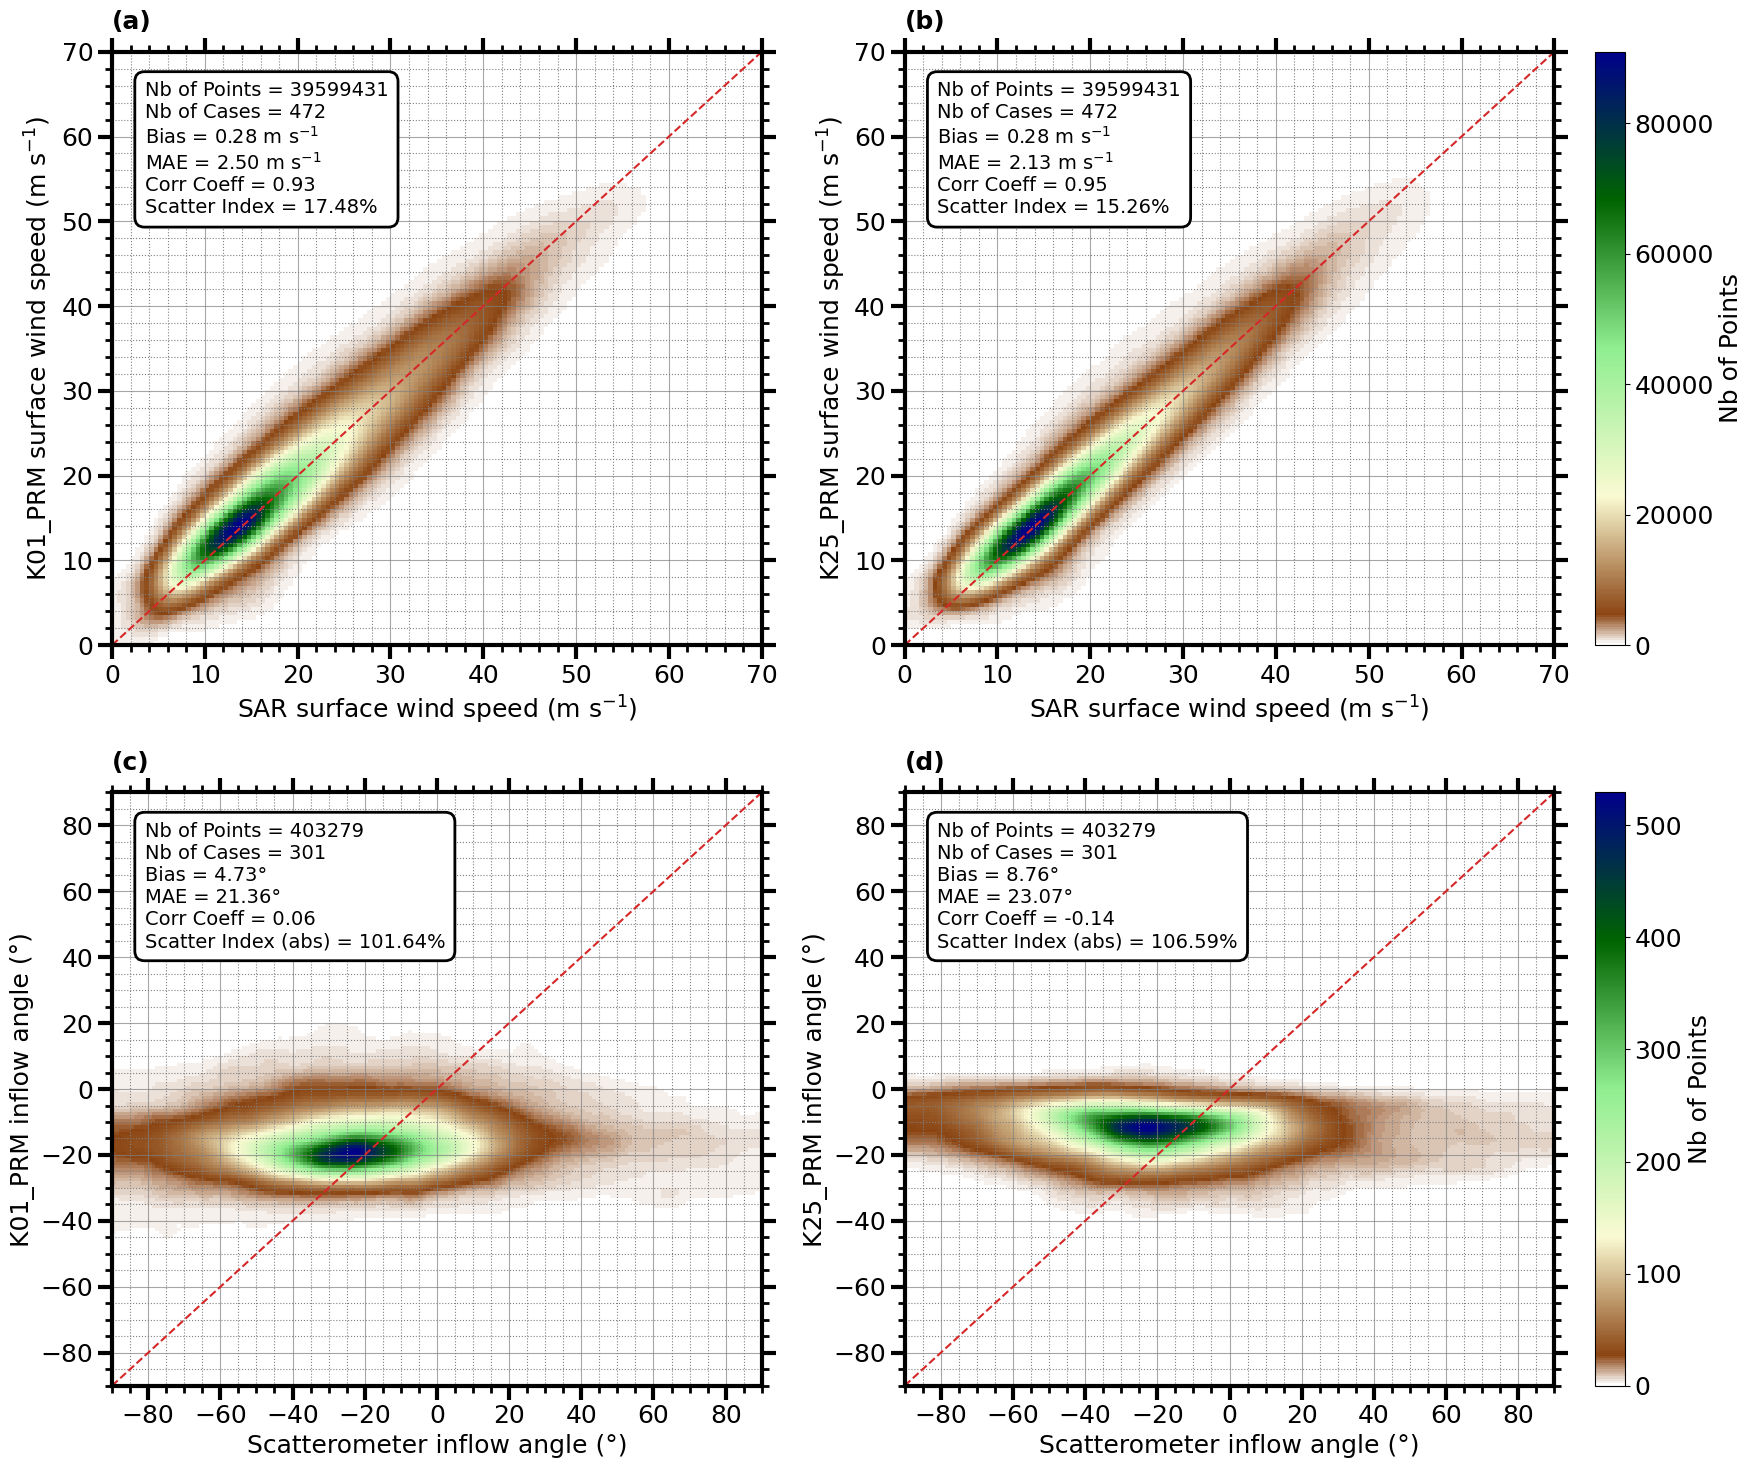

In [70]:
# --- Hyperparameters ---
xbins    = np.linspace(0, 70, 140 + 1)
ybins    = np.linspace(0, 70, 140 + 1)

xbins_ia    = np.linspace(-90, 90, 180 + 1)
ybins_ia    = np.linspace(-90, 90, 180 + 1)
# xbins_ia    = np.linspace(0, 90, 90 + 1)
# ybins_ia    = np.linspace(0, 90, 90 + 1)

ticks_ia    = np.arange(-80, 81, 20)

# Create figure with subplots
fig = plt.figure(figsize=(18, 15))
gs  = GridSpec(2, 2, width_ratios=[1, 1.25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

#####################
### K01 PRM SPEED ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k01          = ~np.isnan(wspds_dsp) & ~np.isnan(wspds_dsk01_prm)
wspds_dsp_cleaned       = wspds_dsp[valid_mask_k01]
wspds_dsk01_prm_cleaned = wspds_dsk01_prm[valid_mask_k01]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    wspds_dsp_cleaned,
    wspds_dsk01_prm_cleaned,
    bins=[xbins, ybins]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax1.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax1.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im1, ax=ax1)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax1.set_xlabel(r'SAR surface wind speed (m s$^{-1}$)')
ax1.set_ylabel('K01_PRM surface wind speed (m s$^{-1}$)')
ax1.set_xlim(0, 70); ax1.set_ylim(0, 70)
ax1.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(wspds_dsk01_prm_cleaned)
n_cases       = len(listOfWspds_dsk01_prm)
differences   = wspds_dsk01_prm_cleaned - wspds_dsp_cleaned
bias          = np.mean(differences)
# std_dev       = np.std(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
correlation   = np.corrcoef(wspds_dsp_cleaned, wspds_dsk01_prm_cleaned)[0, 1]
mean_dsp      = np.mean(wspds_dsp_cleaned)
scatter_index = (rmse / mean_dsp) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f} {r"m s$^{-1}$"}\n"
              f"MAE = {mae:.2f} {r"m s$^{-1}$"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax1.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax1.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
### K25 PRM SPEED ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k25          = ~np.isnan(wspds_dsp) & ~np.isnan(wspds_dsk25_prm)
wspds_dsp_cleaned       = wspds_dsp[valid_mask_k25]
wspds_dsk25_prm_cleaned = wspds_dsk25_prm[valid_mask_k25]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    wspds_dsp_cleaned,
    wspds_dsk25_prm_cleaned,
    bins=[xbins, ybins]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax2.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax2.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im1, ax=ax2)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax2.set_xlabel(r'SAR surface wind speed (m s$^{-1}$)')
ax2.set_ylabel('K25_PRM surface wind speed (m s$^{-1}$)')
ax2.set_xlim(0, 70); ax2.set_ylim(0, 70)
ax2.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(wspds_dsk25_prm_cleaned)
n_cases       = len(listOfWspds_dsk25_prm)
differences   = wspds_dsk25_prm_cleaned - wspds_dsp_cleaned
bias          = np.mean(differences)
# std_dev       = np.std(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
correlation   = np.corrcoef(wspds_dsp_cleaned, wspds_dsk25_prm_cleaned)[0, 1]
mean_dsp      = np.mean(wspds_dsp_cleaned)
scatter_index = (rmse / mean_dsp) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f} {r"m s$^{-1}$"}\n"
              f"MAE = {mae:.2f} {r"m s$^{-1}$"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax2.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax2.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K01 PRM IA   ###
#####################
ax3.text(0.0, 1.03, '(c)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# ias_sct  = abs(ias_sct)
# ias_k01p = abs(ias_k01p)

# --- Nettoyage des données ---
valid_mask_k01   = ~np.isnan(ias_sct) & ~np.isnan(ias_k01p)
ias_sct_cleaned  = ias_sct[valid_mask_k01]
ias_k01p_cleaned = ias_k01p[valid_mask_k01]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_sct_cleaned,
    ias_k01p_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax3.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax3.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im3, ax=ax3)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax3.set_xlabel(r'Scatterometer inflow angle (°)')
ax3.set_ylabel('K01_PRM inflow angle (°)')
ax3.set_xlim(-90, 90); ax3.set_ylim(-90, 90)
ax3.set_xticks(ticks_ia)
ax3.set_yticks(ticks_ia)
ax3.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k01p_cleaned)
n_cases       = np.shape(ias_diffs_k01p_)[0]
differences   = ias_k01p_cleaned - ias_sct_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_sct_cleaned, ias_k01p_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_sct_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax3.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax3.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K25 PRM IA   ###
#####################
ax4.text(0.0, 1.03, '(d)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# ias_sct  = abs(ias_sct)
# ias_k25p = abs(ias_k25p)

# --- Nettoyage des données ---
valid_mask_k25   = ~np.isnan(ias_sct) & ~np.isnan(ias_k25p)
ias_sct_cleaned  = ias_sct[valid_mask_k25]
ias_k25p_cleaned = ias_k25p[valid_mask_k25]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_sct_cleaned,
    ias_k25p_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im3 = ax4.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax4.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im3, ax=ax4)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax4.set_xlabel(r'Scatterometer inflow angle (°)')
ax4.set_ylabel('K25_PRM inflow angle (°)')
ax4.set_xlim(-90, 90); ax4.set_ylim(-90, 90)
ax4.set_xticks(ticks_ia)
ax4.set_yticks(ticks_ia)
ax4.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k25p_cleaned)
n_cases       = np.shape(ias_diffs_k25p_)[0]
differences   = ias_k25p_cleaned - ias_sct_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_sct_cleaned, ias_k25p_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_sct_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax4.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax4.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_PRM_2D_diagnostics.png', bbox_inches='tight')

/tmp/ipykernel_9931/1198598705.py:13: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k01p_), axis=0), linewidth=3, c=c_k01, label='K01_PRM')
/tmp/ipykernel_9931/1198598705.py:14: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k25p_), axis=0), linewidth=3, c=c_k25, label='K25_PRM', linestyle='dashed')
/tmp/ipykernel_9931/1198598705.py:53: RuntimeWarning: Mean of empty slice
  ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k01p_), axis=0), linewidth=3, c=c_k01, label='K01_PRM')
/tmp/ipykernel_9931/1198598705.py:54: RuntimeWarning: Mean of empty slice
  ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k25p_), axis=0), linewidth=3, c=c_k25, label='K25_PRM', linestyle='dashed')


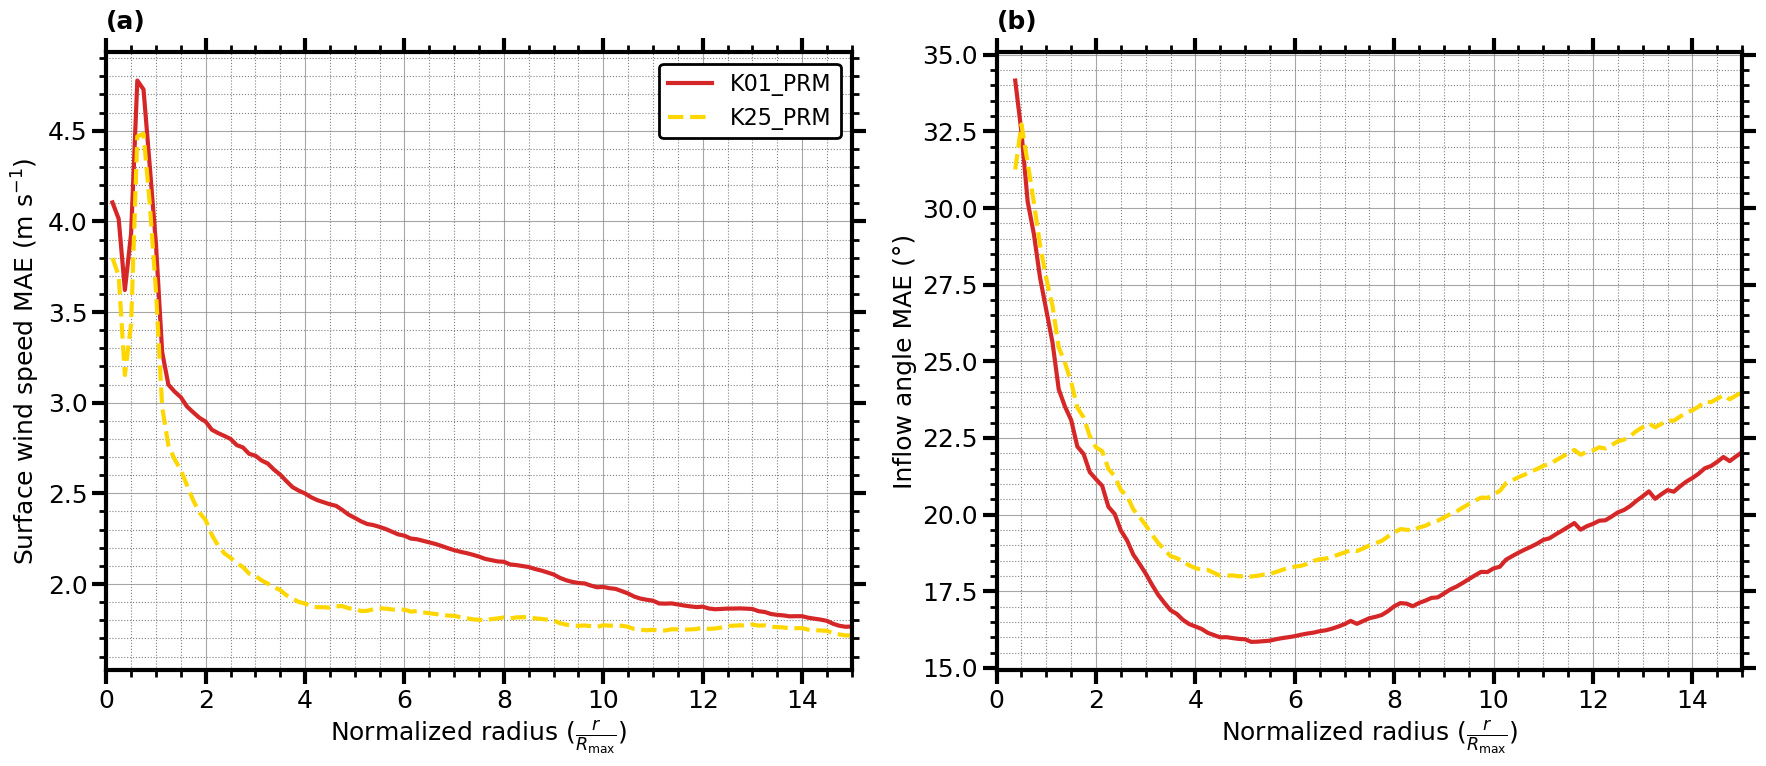

In [71]:
# Create figure with subplots
fig = plt.figure(figsize=(18, 8))
gs  = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

#####################
###   MAE SPEEDS  ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k01p_), axis=0), linewidth=3, c=c_k01, label='K01_PRM')
ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k25p_), axis=0), linewidth=3, c=c_k25, label='K25_PRM', linestyle='dashed')

# Labels
ax1.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax1.set_ylabel('Surface wind speed MAE (m s$^{-1}$)')
ax1.set_xlim(0, 15)
ax1.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Legend
leg = ax1.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)



#####################
###  MAE INF ANG  ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k01p_), axis=0), linewidth=3, c=c_k01, label='K01_PRM')
ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k25p_), axis=0), linewidth=3, c=c_k25, label='K25_PRM', linestyle='dashed')

# Labels
ax2.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax2.set_ylabel('Inflow angle MAE (°)')
ax2.set_xlim(0, 15)
ax2.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_PRM_1D_diagnostics.png', bbox_inches='tight')

#### b) KXX_FIT

In [37]:
### Extract SAR and KXX_FIT wind speed differences and interpolate them on r_star
# (about 2 minutes)

### Initialize
listOfWspds_dsp_k01f  = [] # SAR
listOfWspds_dsp_k25f  = [] # SAR
# K01
listOfWspds_dsk01_fit = [] # K01 param
wspd_diffs_k01f       = [] # Wind speed diffs,                       
wspd_res_k01f         = [] # Wind speed relative errors
wspd_diffs_k01f_      = [] # Wind speed diffs, interp. on r_star                      
wspd_res_k01f_        = [] # Wind speed relative errors, interp. on r_star 
# K25
listOfWspds_dsk25_fit = [] # K25 param
wspd_diffs_k25f       = [] # Wind speed diffs,                       
wspd_res_k25f         = [] # Wind speed relative errors
wspd_diffs_k25f_      = [] # Wind speed diffs, interp. on r_star                       
wspd_res_k25f_        = [] # Wind speed relative errors, interp. on r_star

# K01
for file in tqdm(dk01_clean.dropna(dim='time', subset=['vmx']).file_tcva):
    dsk01_fit         = xr.open_dataset(PTHS['K01_FIT_dir'] + '{}.nc'.format(file.item()[:-17])).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_fit.file_tcva.item(), drop=True).isel(time=0)
    dsp               = xr.open_dataset(PTHS['sar_dir'] + dsk01_fit.file_tcva.item()).isel(time=0).interp(theta=dsk01_fit.theta)

    # Add the non-interpolated wind speeds
    wspd_diff_k01f    = np.subtract(np.array(dsp.wind_speed.transpose()), np.array(dsk01_fit.wind_speed))
    wspd_re_k01f      = np.divide(wspd_diff_k01f, np.array(dsp.wind_speed.transpose()))

    # Interpolate on r_star
    dss, dk01f        = dsp.copy(deep=True), dsk01_fit.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk01f['rad']      = dk01f['rad'] / float(ds.rmx)
    wspd_diff_k01f_   = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk01f.wind_speed.interp(rad=r_star)))
    wspd_re_k01f_     = np.divide(wspd_diff_k01f_, np.array(dss.wind_speed.transpose().interp(rad=r_star)))
    
    ### Append
    # SAR
    listOfWspds_dsp_k01f.append(np.array(dsp.wind_speed.transpose()).flatten())
    # K01 param
    listOfWspds_dsk01_fit.append(np.array(dsk01_fit.wind_speed).flatten())
    wspd_diffs_k01f.append(wspd_diff_k01f)
    wspd_res_k01f.append(wspd_re_k01f)
    wspd_diffs_k01f_.append(wspd_diff_k01f_)
    wspd_res_k01f_.append(wspd_re_k01f_)

    # Close
    dsp.close()
    dsk01_fit.close()
    dss.close()
    dk01f.close()

# K25
for file in tqdm(dk25_clean.dropna(dim='time', subset=['vmx']).file_tcva):
    dsk25_fit         = xr.open_dataset(PTHS['K25_FIT_dir'] + '{}.nc'.format(file.item()[:-17])).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk25_fit.file_tcva.item(), drop=True).isel(time=0)
    dsp               = xr.open_dataset(PTHS['sar_dir'] + dsk25_fit.file_tcva.item()).isel(time=0).interp(theta=dsk25_fit.theta)

    # Add the non-interpolated wind speeds
    wspd_diff_k25f    = np.subtract(np.array(dsp.wind_speed.transpose()), np.array(dsk25_fit.wind_speed))
    wspd_re_k25f      = np.divide(wspd_diff_k25f, np.array(dsp.wind_speed.transpose()))

    # Interpolate on r_star
    dss, dk25f        = dsp.copy(deep=True), dsk25_fit.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk25f['rad']      = dk25f['rad'] / float(ds.rmx)
    wspd_diff_k25f_   = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk25f.wind_speed.interp(rad=r_star)))
    wspd_re_k25f_     = np.divide(wspd_diff_k25f_, np.array(dss.wind_speed.transpose().interp(rad=r_star)))
    
    ### Append
    # SAR
    listOfWspds_dsp_k25f.append(np.array(dsp.wind_speed.transpose()).flatten())
    # K25 param
    listOfWspds_dsk25_fit.append(np.array(dsk25_fit.wind_speed).flatten())
    wspd_diffs_k25f.append(wspd_diff_k25f)
    wspd_res_k25f.append(wspd_re_k25f)
    wspd_diffs_k25f_.append(wspd_diff_k25f_)
    wspd_res_k25f_.append(wspd_re_k25f_)

    # Close
    dsp.close()
    dsk25_fit.close()
    dss.close()
    dk25f.close()

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

In [38]:
### Concatenate the raw wind speeds
wspds_dsp_k01f      = np.concatenate(listOfWspds_dsp_k01f)
wspds_dsp_k25f      = np.concatenate(listOfWspds_dsp_k25f)
wspds_dsk01_fit     = np.concatenate(listOfWspds_dsk01_fit)
wspds_dsk25_fit     = np.concatenate(listOfWspds_dsk25_fit)

### Concatenate the r_star wind speeds
arr_spd_diffs_k01f_ = np.concatenate(wspd_diffs_k01f_)
arr_spd_diffs_k25f_ = np.concatenate(wspd_diffs_k25f_)

In [39]:
### Open inflow angles

# Initialize
list_of_collocated_sct_pths_k01f = []
list_of_collocated_sar_fles_k01f = []
list_of_collocated_sct_pths_k25f = []
list_of_collocated_sar_fles_k25f = []

# K01
for t in tqdm(range(len(dk01_clean.dropna(dim='time', subset=['vmx']).time))):
    ds = dk01_clean.dropna(dim='time', subset=['vmx']).isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths_k01f.append(matching_path)
            list_of_collocated_sar_fles_k01f.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    ds.close()

print(len(list_of_collocated_sct_pths_k01f))

# K25
for t in tqdm(range(len(dk25_clean.dropna(dim='time', subset=['vmx']).time))):
    ds = dk25_clean.dropna(dim='time', subset=['vmx']).isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths_k25f.append(matching_path)
            list_of_collocated_sar_fles_k25f.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    ds.close()

print(len(list_of_collocated_sct_pths_k25f))

  0%|          | 0/282 [00:00<?, ?it/s]

212


  0%|          | 0/221 [00:00<?, ?it/s]

161


In [40]:
# Drop duplicates and keep only first occurrence to match the collocation that was done for KXX_wIA notebooks
dff_clean = pd.DataFrame({'sct': list_of_collocated_sct_pths_k01f, 'sar': list_of_collocated_sar_fles_k01f}).drop_duplicates(subset='sar', keep='first')
list_of_collocated_sct_pths_k01f = dff_clean['sct'].tolist()
list_of_collocated_sar_fles_k01f = dff_clean['sar'].tolist()
dff_clean = pd.DataFrame({'sct': list_of_collocated_sct_pths_k25f, 'sar': list_of_collocated_sar_fles_k25f}).drop_duplicates(subset='sar', keep='first')
list_of_collocated_sct_pths_k25f = dff_clean['sct'].tolist()
list_of_collocated_sar_fles_k25f = dff_clean['sar'].tolist()

In [41]:
### Open data
# (about 1 minute)

# SCAT
dsc_sct_k01f = xr.open_mfdataset(list_of_collocated_sct_pths_k01f, combine='nested', concat_dim='idx')
dsc_sct_k25f = xr.open_mfdataset(list_of_collocated_sct_pths_k25f, combine='nested', concat_dim='idx')
# K01 FIT
dsk01f  = xr.open_mfdataset([PTHS['K01_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles_k01f], combine='nested', concat_dim='idx')
# K25 FIT
dsk25f  = xr.open_mfdataset([PTHS['K25_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles_k25f], combine='nested', concat_dim='idx')

In [42]:
### Eventually, mask rain
if PRMS['mask_rain']:
    dsc_sct_k01f['inflow_angle'] = dsc_sct_k01f.where(dsc_sct_k01f.rain_flag == 0).inflow_angle
    dsc_sct_k25f['inflow_angle'] = dsc_sct_k25f.where(dsc_sct_k25f.rain_flag == 0).inflow_angle

In [43]:
### Eventually compute the absolute inflow angle
dsc_sct_k01f['inflow_angle'] = np.rad2deg(np.arctan(dsc_sct_k01f.radial_wind / abs(dsc_sct_k01f.tangential_wind))) 
dsc_sct_k25f['inflow_angle'] = np.rad2deg(np.arctan(dsc_sct_k25f.radial_wind / abs(dsc_sct_k25f.tangential_wind))) 
dsk01f['inflow_angle']       = np.rad2deg(np.arctan(dsk01f.rad_wind     / abs(dsk01f.tan_wind))) 
dsk25f['inflow_angle']       = np.rad2deg(np.arctan(dsk25f.rad_wind     / abs(dsk25f.tan_wind))) 

In [44]:
### Flatten raw inflow angles
ias_sct_k01f = np.array(dsc_sct_k01f.inflow_angle).flatten()
ias_sct_k25f = np.array(dsc_sct_k25f.inflow_angle).flatten()
ias_k01f     = np.array(dsk01f.sel(z=10).interp(theta=dsc_sct_k01f.theta, rad=dsc_sct_k01f.rad, method='nearest').inflow_angle).flatten()
ias_k25f     = np.array(dsk25f.sel(z=10).interp(theta=dsc_sct_k25f.theta, rad=dsc_sct_k25f.rad, method='nearest').inflow_angle).flatten()

In [45]:
### Interpolate inflow angles on r_star
# (about 1 minute)

### Initialize
# K01 param
ias_diffs_k01f_ = [] # K01 fit
# K25 param
ias_diffs_k25f_ = [] # K25 fit

# K01 FIT
for i in tqdm(range(len(dsk01f.idx))):
    file_tcva    = dsk01f.isel(idx=i).file_tcva
    ds           = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva.item(), drop=True).isel(time=0)
    dss, dk01f   = dsc_sct_k01f.isel(idx=i).copy(deep=True), dsk01f.sel(z=10).isel(idx=i).copy(deep=True)
    # Transform coordinate
    dss['rad']   = dss['rad'] / float(ds.rmx)
    dk01f['rad'] = dk01f['rad'] / float(ds.rmx)
    # Compute relative errors
    diff         = np.subtract(np.array(dss.inflow_angle.interp(rad=r_star)), np.array(dk01f.inflow_angle.interp(rad=r_star).interp(theta=dss.theta, method='nearest')))
    # Append
    ias_diffs_k01f_.append(diff)
    # Close
    dss.close()
    dk01f.close()

# K25 FIT
for i in tqdm(range(len(dsk25f.idx))):
    file_tcva    = dsk25f.isel(idx=i).file_tcva
    ds           = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva.item(), drop=True).isel(time=0)
    dss, dk25f   = dsc_sct_k25f.isel(idx=i).copy(deep=True), dsk25f.sel(z=10).isel(idx=i).copy(deep=True)
    # Transform coordinate
    dss['rad']   = dss['rad'] / float(ds.rmx)
    dk25f['rad'] = dk25f['rad'] / float(ds.rmx)
    # Compute relative errors
    diff         = np.subtract(np.array(dss.inflow_angle.interp(rad=r_star)), np.array(dk25f.inflow_angle.interp(rad=r_star).interp(theta=dss.theta, method='nearest')))
    # Append
    ias_diffs_k25f_.append(diff)
    # Close
    dss.close()
    dk25f.close()

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

In [46]:
### Concatenate the r_star inflow angles
arr_ia_diffs_k01f_ = np.concatenate(ias_diffs_k01f_)
arr_ia_diffs_k25f_ = np.concatenate(ias_diffs_k25f_)

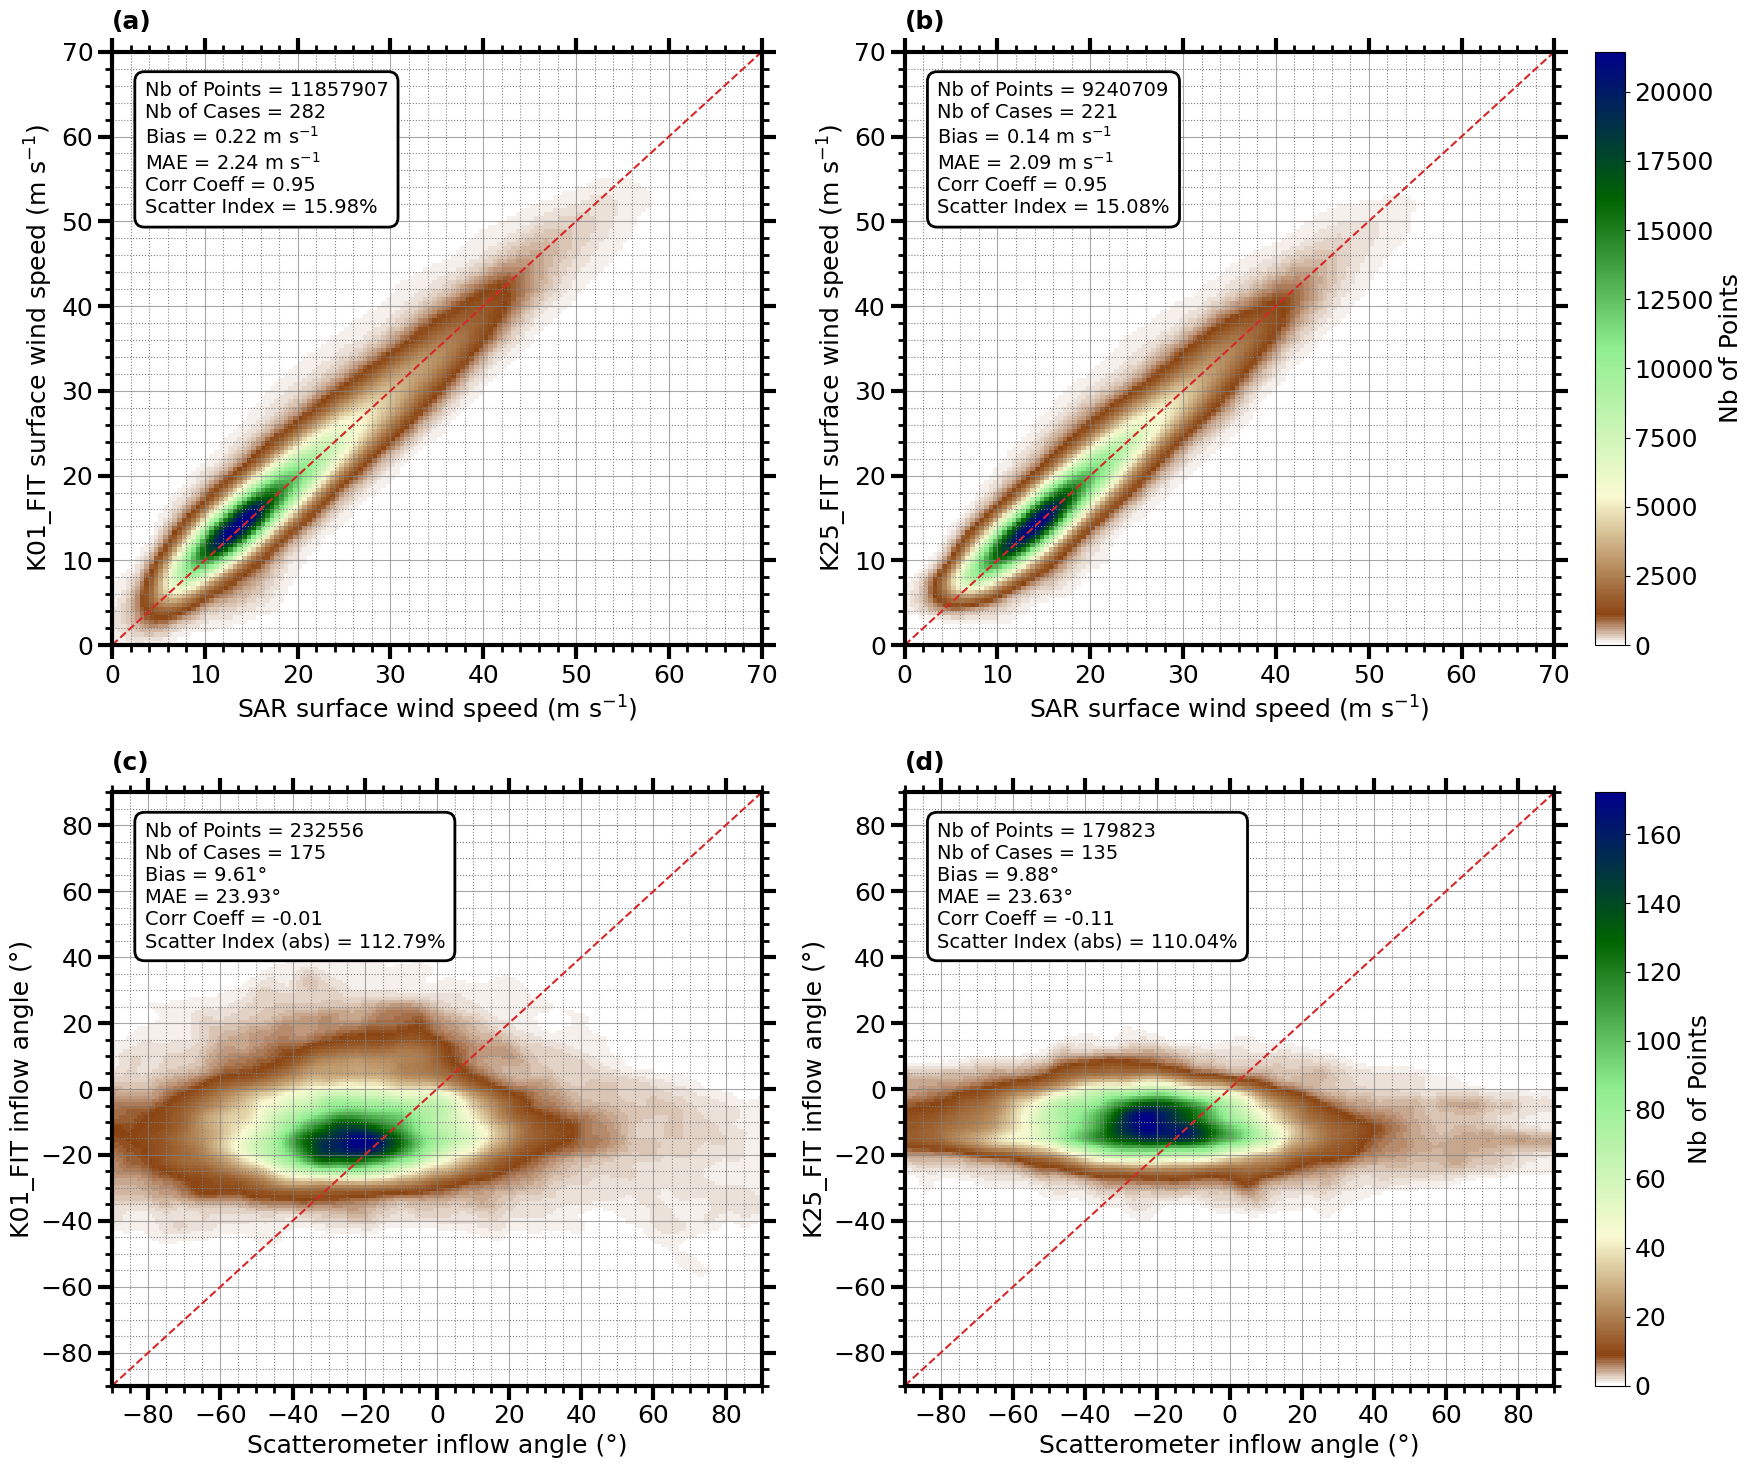

In [50]:
# --- Hyperparameters ---
xbins    = np.linspace(0, 70, 140 + 1)
ybins    = np.linspace(0, 70, 140 + 1)

xbins_ia    = np.linspace(-90, 90, 180 + 1)
ybins_ia    = np.linspace(-90, 90, 180 + 1)
# xbins_ia    = np.linspace(0, 90, 90 + 1)
# ybins_ia    = np.linspace(0, 90, 90 + 1)

ticks_ia    = np.arange(-80, 81, 20)

# Create figure with subplots
fig = plt.figure(figsize=(18, 15))
gs  = GridSpec(2, 2, width_ratios=[1, 1.25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

#####################
### K01 PRM SPEED ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k01f         = ~np.isnan(wspds_dsp_k01f) & ~np.isnan(wspds_dsk01_fit)
wspds_dsp_k01f_cleaned  = wspds_dsp_k01f[valid_mask_k01f]
wspds_dsk01_fit_cleaned = wspds_dsk01_fit[valid_mask_k01f]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    wspds_dsp_k01f_cleaned,
    wspds_dsk01_fit_cleaned,
    bins=[xbins, ybins]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax1.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax1.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im1, ax=ax1)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax1.set_xlabel(r'SAR surface wind speed (m s$^{-1}$)')
ax1.set_ylabel('K01_FIT surface wind speed (m s$^{-1}$)')
ax1.set_xlim(0, 70); ax1.set_ylim(0, 70)
ax1.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(wspds_dsk01_fit_cleaned)
n_cases       = len(listOfWspds_dsk01_fit)
differences   = wspds_dsk01_fit_cleaned - wspds_dsp_k01f_cleaned
bias          = np.mean(differences)
# std_dev       = np.std(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
correlation   = np.corrcoef(wspds_dsp_k01f_cleaned, wspds_dsk01_fit_cleaned)[0, 1]
mean_dsp      = np.mean(wspds_dsp_k01f_cleaned)
scatter_index = (rmse / mean_dsp) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f} {r"m s$^{-1}$"}\n"
              f"MAE = {mae:.2f} {r"m s$^{-1}$"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax1.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax1.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
### K25 PRM SPEED ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k25f         = ~np.isnan(wspds_dsp_k25f) & ~np.isnan(wspds_dsk25_fit)
wspds_dsp_k25f_cleaned  = wspds_dsp_k25f[valid_mask_k25f]
wspds_dsk25_fit_cleaned = wspds_dsk25_fit[valid_mask_k25f]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    wspds_dsp_k25f_cleaned,
    wspds_dsk25_fit_cleaned,
    bins=[xbins, ybins]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax2.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax2.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im1, ax=ax2)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax2.set_xlabel(r'SAR surface wind speed (m s$^{-1}$)')
ax2.set_ylabel('K25_FIT surface wind speed (m s$^{-1}$)')
ax2.set_xlim(0, 70); ax2.set_ylim(0, 70)
ax2.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(wspds_dsk25_fit_cleaned)
n_cases       = len(listOfWspds_dsk25_fit)
differences   = wspds_dsk25_fit_cleaned - wspds_dsp_k25f_cleaned
bias          = np.mean(differences)
# std_dev       = np.std(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
correlation   = np.corrcoef(wspds_dsp_k25f_cleaned, wspds_dsk25_fit_cleaned)[0, 1]
mean_dsp      = np.mean(wspds_dsp_k25f_cleaned)
scatter_index = (rmse / mean_dsp) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f} {r"m s$^{-1}$"}\n"
              f"MAE = {mae:.2f} {r"m s$^{-1}$"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax2.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax2.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K01 PRM IA   ###
#####################
ax3.text(0.0, 1.03, '(c)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k01f      = ~np.isnan(ias_sct_k01f) & ~np.isnan(ias_k01f)
ias_sct_k01f_cleaned = ias_sct_k01f[valid_mask_k01f]
ias_k01f_cleaned     = ias_k01f[valid_mask_k01f]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_sct_k01f_cleaned,
    ias_k01f_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax3.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax3.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im3, ax=ax3)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax3.set_xlabel(r'Scatterometer inflow angle (°)')
ax3.set_ylabel('K01_FIT inflow angle (°)')
ax3.set_xlim(-90, 90); ax3.set_ylim(-90, 90)
ax3.set_xticks(ticks_ia)
ax3.set_yticks(ticks_ia)
ax3.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k01f_cleaned)
n_cases       = np.shape(ias_diffs_k01f_)[0]
differences   = ias_k01f_cleaned - ias_sct_k01f_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_sct_k01f_cleaned, ias_k01f_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_sct_k01f_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax3.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax3.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K25 PRM IA   ###
#####################
ax4.text(0.0, 1.03, '(d)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k25f      = ~np.isnan(ias_sct_k25f) & ~np.isnan(ias_k25f)
ias_sct_k25f_cleaned = ias_sct_k25f[valid_mask_k25f]
ias_k25f_cleaned     = ias_k25f[valid_mask_k25f]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_sct_k25f_cleaned,
    ias_k25f_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im3 = ax4.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax4.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im3, ax=ax4)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax4.set_xlabel(r'Scatterometer inflow angle (°)')
ax4.set_ylabel('K25_FIT inflow angle (°)')
ax4.set_xlim(-90, 90); ax4.set_ylim(-90, 90)
ax4.set_xticks(ticks_ia)
ax4.set_yticks(ticks_ia)
ax4.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k25f_cleaned)
n_cases       = np.shape(ias_diffs_k25f_)[0]
differences   = ias_k25f_cleaned - ias_sct_k25f_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_sct_k25f_cleaned, ias_k25f_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_sct_k25f_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax4.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax4.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_FIT_2D_diagnostics.png', bbox_inches='tight')

/tmp/ipykernel_17418/565728395.py:13: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k01f_), axis=0), linewidth=3, c=c_k01, label='K01_FIT')
/tmp/ipykernel_17418/565728395.py:14: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k25f_), axis=0), linewidth=3, c=c_k25, label='K25_FIT', linestyle='dashed')
/tmp/ipykernel_17418/565728395.py:53: RuntimeWarning: Mean of empty slice
  ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k01f_), axis=0), linewidth=3, c=c_k01, label='K01_FIT')
/tmp/ipykernel_17418/565728395.py:54: RuntimeWarning: Mean of empty slice
  ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k25f_), axis=0), linewidth=3, c=c_k25, label='K25_FIT', linestyle='dashed')


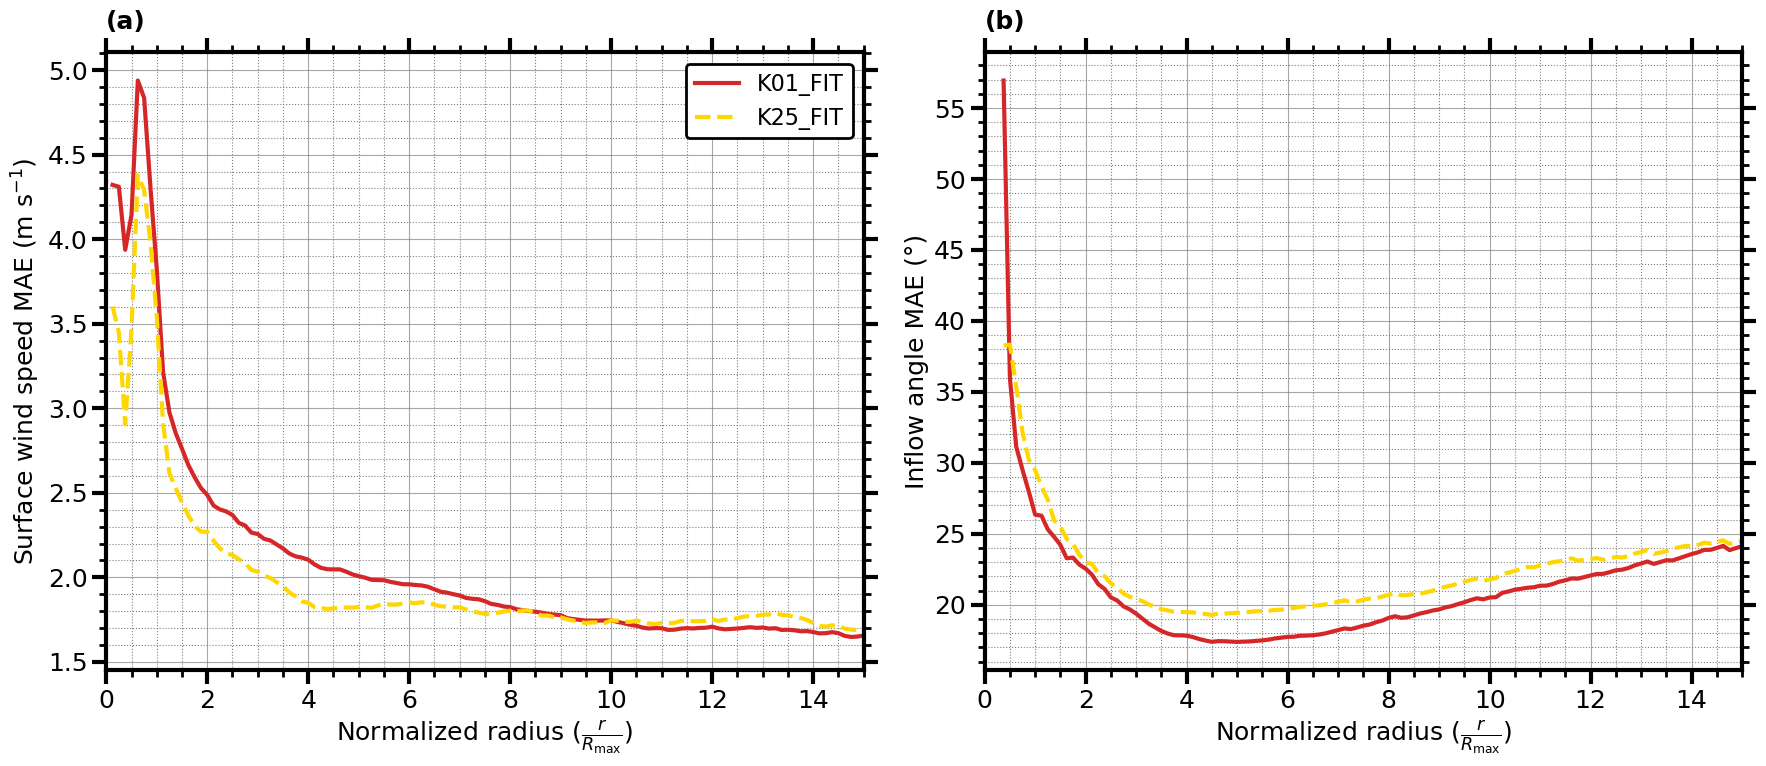

In [51]:
# Create figure with subplots
fig = plt.figure(figsize=(18, 8))
gs  = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

#####################
###   MAE SPEEDS  ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k01f_), axis=0), linewidth=3, c=c_k01, label='K01_FIT')
ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k25f_), axis=0), linewidth=3, c=c_k25, label='K25_FIT', linestyle='dashed')

# Labels
ax1.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax1.set_ylabel('Surface wind speed MAE (m s$^{-1}$)')
ax1.set_xlim(0, 15)
ax1.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Legend
leg = ax1.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)



#####################
###  MAE INF ANG  ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k01f_), axis=0), linewidth=3, c=c_k01, label='K01_FIT')
ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k25f_), axis=0), linewidth=3, c=c_k25, label='K25_FIT', linestyle='dashed')

# Labels
ax2.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax2.set_ylabel('Inflow angle MAE (°)')
ax2.set_xlim(0, 15)
ax2.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_FIT_1D_diagnostics.png', bbox_inches='tight')

#### c) KXX_wIA

In [37]:
### Extract SAR and KXX_wIA wind speed differences and interpolate them on r_star
# (about 2 minutes)

### Initialize
listOfWspds_dsp_k01i  = [] # SAR
listOfWspds_dsp_k25i  = [] # SAR
# K01
listOfWspds_dsk01_wIA = [] # K01 wIA
wspd_diffs_k01i       = [] # Wind speed diffs,                       
wspd_res_k01i         = [] # Wind speed relative errors
wspd_diffs_k01i_      = [] # Wind speed diffs, interp. on r_star                      
wspd_res_k01i_        = [] # Wind speed relative errors, interp. on r_star 
# K25
listOfWspds_dsk25_wIA = [] # K25 wIA
wspd_diffs_k25i       = [] # Wind speed diffs,                       
wspd_res_k25i         = [] # Wind speed relative errors
wspd_diffs_k25i_      = [] # Wind speed diffs, interp. on r_star                       
wspd_res_k25i_        = [] # Wind speed relative errors, interp. on r_star

# K01
for file in tqdm(dk01i_clean.dropna(dim='time', subset=['vmx']).file_tcva):
    dsk01_wIA         = xr.open_dataset(PTHS['K01_wIA_dir'] + '{}.nc'.format(file.item()[:-17])).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_wIA.file_tcva.item(), drop=True).isel(time=0)
    dsp               = xr.open_dataset(PTHS['sar_dir'] + dsk01_wIA.file_tcva.item()).isel(time=0).interp(theta=dsk01_wIA.theta)

    # Add the non-interpolated wind speeds
    wspd_diff_k01i    = np.subtract(np.array(dsp.wind_speed.transpose()), np.array(dsk01_wIA.wind_speed))
    wspd_re_k01i      = np.divide(wspd_diff_k01i, np.array(dsp.wind_speed.transpose()))

    # Interpolate on r_star
    dss, dk01i        = dsp.copy(deep=True), dsk01_wIA.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk01i['rad']      = dk01i['rad'] / float(ds.rmx)
    wspd_diff_k01i_   = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk01i.wind_speed.interp(rad=r_star)))
    wspd_re_k01i_     = np.divide(wspd_diff_k01i_, np.array(dss.wind_speed.transpose().interp(rad=r_star)))
    
    ### Append
    # SAR
    listOfWspds_dsp_k01i.append(np.array(dsp.wind_speed.transpose()).flatten())
    # K01 param
    listOfWspds_dsk01_wIA.append(np.array(dsk01_wIA.wind_speed).flatten())
    wspd_diffs_k01i.append(wspd_diff_k01i)
    wspd_res_k01i.append(wspd_re_k01i)
    wspd_diffs_k01i_.append(wspd_diff_k01i_)
    wspd_res_k01i_.append(wspd_re_k01i_)

    # Close
    dsp.close()
    dsk01_wIA.close()
    dss.close()
    dk01i.close()

# K25
for file in tqdm(dk25i_clean.dropna(dim='time', subset=['vmx']).file_tcva):
    dsk25_wIA         = xr.open_dataset(PTHS['K25_wIA_dir'] + '{}.nc'.format(file.item()[:-17])).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk25_wIA.file_tcva.item(), drop=True).isel(time=0)
    dsp               = xr.open_dataset(PTHS['sar_dir'] + dsk25_wIA.file_tcva.item()).isel(time=0).interp(theta=dsk25_wIA.theta)

    # Add the non-interpolated wind speeds
    wspd_diff_k25i    = np.subtract(np.array(dsp.wind_speed.transpose()), np.array(dsk25_wIA.wind_speed))
    wspd_re_k25i      = np.divide(wspd_diff_k25i, np.array(dsp.wind_speed.transpose()))

    # Interpolate on r_star
    dss, dk25i        = dsp.copy(deep=True), dsk25_wIA.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk25i['rad']      = dk25i['rad'] / float(ds.rmx)
    wspd_diff_k25i_   = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk25i.wind_speed.interp(rad=r_star)))
    wspd_re_k25i_     = np.divide(wspd_diff_k25i_, np.array(dss.wind_speed.transpose().interp(rad=r_star)))
    
    ### Append
    # SAR
    listOfWspds_dsp_k25i.append(np.array(dsp.wind_speed.transpose()).flatten())
    # K25 param
    listOfWspds_dsk25_wIA.append(np.array(dsk25_wIA.wind_speed).flatten())
    wspd_diffs_k25i.append(wspd_diff_k25i)
    wspd_res_k25i.append(wspd_re_k25i)
    wspd_diffs_k25i_.append(wspd_diff_k25i_)
    wspd_res_k25i_.append(wspd_re_k25i_)

    # Close
    dsp.close()
    dsk25_wIA.close()
    dss.close()
    dk25i.close()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

In [38]:
### Concatenate the raw wind speeds
wspds_dsp_k01i      = np.concatenate(listOfWspds_dsp_k01i)
wspds_dsp_k25i      = np.concatenate(listOfWspds_dsp_k25i)
wspds_dsk01_wIA     = np.concatenate(listOfWspds_dsk01_wIA)
wspds_dsk25_wIA     = np.concatenate(listOfWspds_dsk25_wIA)

### Concatenate the r_star wind speeds
arr_spd_diffs_k01i_ = np.concatenate(wspd_diffs_k01i_)
arr_spd_diffs_k25i_ = np.concatenate(wspd_diffs_k25i_)

In [39]:
### Open inflow angles

# Initialize
list_of_collocated_sct_pths_k01i = []
list_of_collocated_sar_fles_k01i = []
list_of_collocated_sct_pths_k25i = []
list_of_collocated_sar_fles_k25i = []

# K01
for t in tqdm(range(len(dk01i_clean.dropna(dim='time', subset=['vmx']).time))):
    ds = dk01i_clean.dropna(dim='time', subset=['vmx']).isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths_k01i.append(matching_path)
            list_of_collocated_sar_fles_k01i.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    ds.close()

print(len(list_of_collocated_sct_pths_k01i))

# K25
for t in tqdm(range(len(dk25i_clean.dropna(dim='time', subset=['vmx']).time))):
    ds = dk25i_clean.dropna(dim='time', subset=['vmx']).isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths_k25i.append(matching_path)
            list_of_collocated_sar_fles_k25i.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    ds.close()

print(len(list_of_collocated_sct_pths_k25i))

  0%|          | 0/200 [00:00<?, ?it/s]

240


  0%|          | 0/187 [00:00<?, ?it/s]

228


In [40]:
# Drop duplicates and keep only first occurrence to match the collocation that was done for KXX_wIA notebooks
dfi_clean = pd.DataFrame({'sct': list_of_collocated_sct_pths_k01i, 'sar': list_of_collocated_sar_fles_k01i}).drop_duplicates(subset='sar', keep='first')
list_of_collocated_sct_pths_k01i = dfi_clean['sct'].tolist()
list_of_collocated_sar_fles_k01i = dfi_clean['sar'].tolist()
dfi_clean = pd.DataFrame({'sct': list_of_collocated_sct_pths_k25i, 'sar': list_of_collocated_sar_fles_k25i}).drop_duplicates(subset='sar', keep='first')
list_of_collocated_sct_pths_k25i = dfi_clean['sct'].tolist()
list_of_collocated_sar_fles_k25i = dfi_clean['sar'].tolist()

In [41]:
### Open data
# (about 1 minute)

# SCAT
dsc_sct_k01i = xr.open_mfdataset(list_of_collocated_sct_pths_k01i, combine='nested', concat_dim='idx')
dsc_sct_k25i = xr.open_mfdataset(list_of_collocated_sct_pths_k25i, combine='nested', concat_dim='idx')
# K01 wIA
dsk01i  = xr.open_mfdataset([PTHS['K01_wIA_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles_k01i], combine='nested', concat_dim='idx')
# K25 wIA
dsk25i  = xr.open_mfdataset([PTHS['K25_wIA_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles_k25i], combine='nested', concat_dim='idx')

In [42]:
### Eventually, mask rain
if PRMS['mask_rain']:
    dsc_sct_k01i['inflow_angle'] = dsc_sct_k01i.where(dsc_sct_k01i.rain_flag == 0).inflow_angle
    dsc_sct_k25i['inflow_angle'] = dsc_sct_k25i.where(dsc_sct_k25i.rain_flag == 0).inflow_angle

In [43]:
### Eventually compute the absolute inflow angle
dsc_sct_k01i['inflow_angle'] = np.rad2deg(np.arctan(dsc_sct_k01i.radial_wind / abs(dsc_sct_k01i.tangential_wind))) 
dsc_sct_k25i['inflow_angle'] = np.rad2deg(np.arctan(dsc_sct_k25i.radial_wind / abs(dsc_sct_k25i.tangential_wind))) 
dsk01i['inflow_angle']       = np.rad2deg(np.arctan(dsk01i.rad_wind     / abs(dsk01i.tan_wind))) 
dsk25i['inflow_angle']       = np.rad2deg(np.arctan(dsk25i.rad_wind     / abs(dsk25i.tan_wind))) 

In [44]:
### Flatten raw inflow angles
ias_sct_k01i = np.array(dsc_sct_k01i.inflow_angle).flatten()
ias_sct_k25i = np.array(dsc_sct_k25i.inflow_angle).flatten()
ias_k01i     = np.array(dsk01i.sel(z=10).interp(theta=dsc_sct_k01i.theta, rad=dsc_sct_k01i.rad, method='nearest').inflow_angle).flatten()
ias_k25i     = np.array(dsk25i.sel(z=10).interp(theta=dsc_sct_k25i.theta, rad=dsc_sct_k25i.rad, method='nearest').inflow_angle).flatten()

In [45]:
### Interpolate inflow angles on r_star
# (about 1 minute)

### Initialize
# K01 wIA
ias_diffs_k01i_ = [] # K01 wIA
# K25 wIA
ias_diffs_k25i_ = [] # K25 wIA

# K01 wIA
for i in tqdm(range(len(dsk01i.idx))):
    file_tcva    = dsk01i.isel(idx=i).file_tcva
    ds           = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva.item(), drop=True).isel(time=0)
    dss, dk01i   = dsc_sct_k01i.isel(idx=i).copy(deep=True), dsk01i.sel(z=10).isel(idx=i).copy(deep=True)
    # Transform coordinate
    dss['rad']   = dss['rad'] / float(ds.rmx)
    dk01i['rad'] = dk01i['rad'] / float(ds.rmx)
    # Compute relative errors
    diff         = np.subtract(np.array(dss.inflow_angle.interp(rad=r_star)), np.array(dk01i.inflow_angle.interp(rad=r_star).interp(theta=dss.theta, method='nearest')))
    # Append
    ias_diffs_k01i_.append(diff)
    # Close
    dss.close()
    dk01i.close()

# K25 wIA
for i in tqdm(range(len(dsk25i.idx))):
    file_tcva    = dsk25i.isel(idx=i).file_tcva
    ds           = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva.item(), drop=True).isel(time=0)
    dss, dk25i   = dsc_sct_k25i.isel(idx=i).copy(deep=True), dsk25i.sel(z=10).isel(idx=i).copy(deep=True)
    # Transform coordinate
    dss['rad']   = dss['rad'] / float(ds.rmx)
    dk25i['rad'] = dk25i['rad'] / float(ds.rmx)
    # Compute relative errors
    diff         = np.subtract(np.array(dss.inflow_angle.interp(rad=r_star)), np.array(dk25i.inflow_angle.interp(rad=r_star).interp(theta=dss.theta, method='nearest')))
    # Append
    ias_diffs_k25i_.append(diff)
    # Close
    dss.close()
    dk25i.close()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

In [46]:
### Concatenate the r_star inflow angles
arr_ia_diffs_k01i_ = np.concatenate(ias_diffs_k01i_)
arr_ia_diffs_k25i_ = np.concatenate(ias_diffs_k25i_)

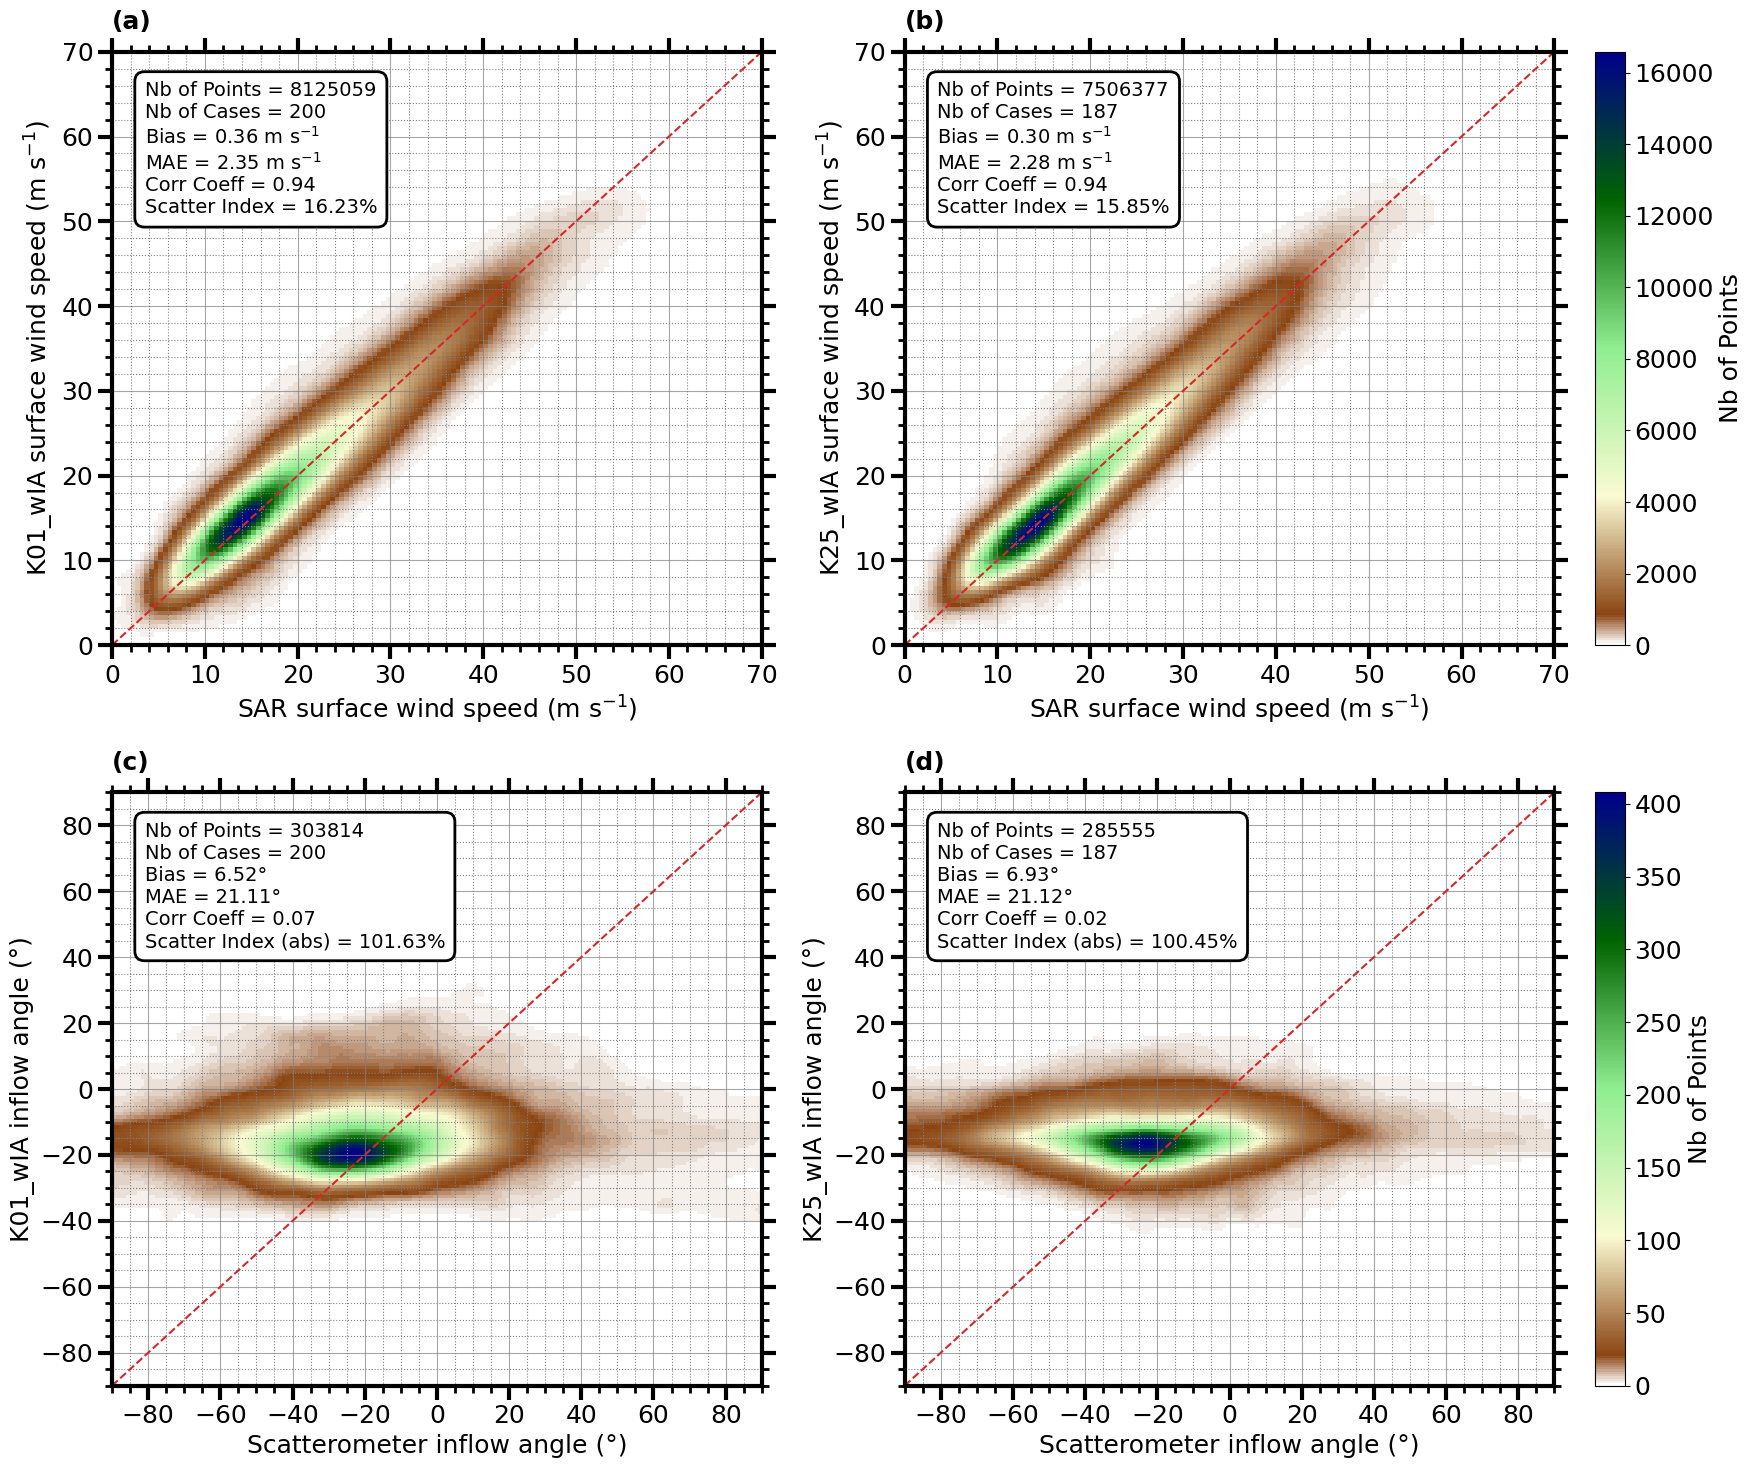

In [47]:
# --- Hyperparameters ---
xbins    = np.linspace(0, 70, 140 + 1)
ybins    = np.linspace(0, 70, 140 + 1)

xbins_ia    = np.linspace(-90, 90, 180 + 1)
ybins_ia    = np.linspace(-90, 90, 180 + 1)
# xbins_ia    = np.linspace(0, 90, 90 + 1)
# ybins_ia    = np.linspace(0, 90, 90 + 1)

ticks_ia    = np.arange(-80, 81, 20)

# Create figure with subplots
fig = plt.figure(figsize=(18, 15))
gs  = GridSpec(2, 2, width_ratios=[1, 1.25])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

#####################
### K01 wIA SPEED ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k01i         = ~np.isnan(wspds_dsp_k01i) & ~np.isnan(wspds_dsk01_wIA)
wspds_dsp_k01i_cleaned  = wspds_dsp_k01i[valid_mask_k01i]
wspds_dsk01_wIA_cleaned = wspds_dsk01_wIA[valid_mask_k01i]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    wspds_dsp_k01i_cleaned,
    wspds_dsk01_wIA_cleaned,
    bins=[xbins, ybins]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax1.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax1.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im1, ax=ax1)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax1.set_xlabel(r'SAR surface wind speed (m s$^{-1}$)')
ax1.set_ylabel('K01_wIA surface wind speed (m s$^{-1}$)')
ax1.set_xlim(0, 70); ax1.set_ylim(0, 70)
ax1.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(wspds_dsk01_wIA_cleaned)
n_cases       = len(listOfWspds_dsk01_wIA)
differences   = wspds_dsk01_wIA_cleaned - wspds_dsp_k01i_cleaned
bias          = np.mean(differences)
# std_dev       = np.std(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
correlation   = np.corrcoef(wspds_dsp_k01i_cleaned, wspds_dsk01_wIA_cleaned)[0, 1]
mean_dsp      = np.mean(wspds_dsp_k01i_cleaned)
scatter_index = (rmse / mean_dsp) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f} {r"m s$^{-1}$"}\n"
              f"MAE = {mae:.2f} {r"m s$^{-1}$"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax1.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax1.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
### K25 wIA SPEED ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k25i         = ~np.isnan(wspds_dsp_k25i) & ~np.isnan(wspds_dsk25_wIA)
wspds_dsp_k25i_cleaned  = wspds_dsp_k25i[valid_mask_k25i]
wspds_dsk25_wIA_cleaned = wspds_dsk25_wIA[valid_mask_k25i]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    wspds_dsp_k25i_cleaned,
    wspds_dsk25_wIA_cleaned,
    bins=[xbins, ybins]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax2.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax2.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im1, ax=ax2)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax2.set_xlabel(r'SAR surface wind speed (m s$^{-1}$)')
ax2.set_ylabel('K25_wIA surface wind speed (m s$^{-1}$)')
ax2.set_xlim(0, 70); ax2.set_ylim(0, 70)
ax2.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(wspds_dsk25_wIA_cleaned)
n_cases       = len(listOfWspds_dsk25_wIA)
differences   = wspds_dsk25_wIA_cleaned - wspds_dsp_k25i_cleaned
bias          = np.mean(differences)
# std_dev       = np.std(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
correlation   = np.corrcoef(wspds_dsp_k25i_cleaned, wspds_dsk25_wIA_cleaned)[0, 1]
mean_dsp      = np.mean(wspds_dsp_k25i_cleaned)
scatter_index = (rmse / mean_dsp) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f} {r"m s$^{-1}$"}\n"
              f"MAE = {mae:.2f} {r"m s$^{-1}$"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax2.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax2.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K01 wIA IA   ###
#####################
ax3.text(0.0, 1.03, '(c)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k01i      = ~np.isnan(ias_sct_k01i) & ~np.isnan(ias_k01i)
ias_sct_k01i_cleaned = ias_sct_k01i[valid_mask_k01i]
ias_k01i_cleaned     = ias_k01i[valid_mask_k01i]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_sct_k01i_cleaned,
    ias_k01i_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax3.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax3.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im3, ax=ax3)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax3.set_xlabel(r'Scatterometer inflow angle (°)')
ax3.set_ylabel('K01_wIA inflow angle (°)')
ax3.set_xlim(-90, 90); ax3.set_ylim(-90, 90)
ax3.set_xticks(ticks_ia)
ax3.set_yticks(ticks_ia)
ax3.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k01i_cleaned)
n_cases       = np.shape(ias_diffs_k01i_)[0]
differences   = ias_k01i_cleaned - ias_sct_k01i_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_sct_k01i_cleaned, ias_k01i_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_sct_k01i_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax3.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax3.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K25 wIA IA   ###
#####################
ax4.text(0.0, 1.03, '(d)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k25i      = ~np.isnan(ias_sct_k25i) & ~np.isnan(ias_k25i)
ias_sct_k25i_cleaned = ias_sct_k25i[valid_mask_k25i]
ias_k25i_cleaned     = ias_k25i[valid_mask_k25i]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_sct_k25i_cleaned,
    ias_k25i_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im3 = ax4.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax4.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im3, ax=ax4)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax4.set_xlabel(r'Scatterometer inflow angle (°)')
ax4.set_ylabel('K25_wIA inflow angle (°)')
ax4.set_xlim(-90, 90); ax4.set_ylim(-90, 90)
ax4.set_xticks(ticks_ia)
ax4.set_yticks(ticks_ia)
ax4.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k25i_cleaned)
n_cases       = np.shape(ias_diffs_k25i_)[0]
differences   = ias_k25i_cleaned - ias_sct_k25i_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_sct_k25i_cleaned, ias_k25i_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_sct_k25i_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax4.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax4.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_wIA_2D_diagnostics.png', bbox_inches='tight')

/tmp/ipykernel_17784/3496112578.py:13: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k01i_), axis=0), linewidth=3, c=c_k01, label='K01_wIA')
/tmp/ipykernel_17784/3496112578.py:14: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k25i_), axis=0), linewidth=3, c=c_k25, label='K25_wIA', linestyle='dashed')
/tmp/ipykernel_17784/3496112578.py:53: RuntimeWarning: Mean of empty slice
  ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k01i_), axis=0), linewidth=3, c=c_k01, label='K01_wIA')
/tmp/ipykernel_17784/3496112578.py:54: RuntimeWarning: Mean of empty slice
  ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k25i_), axis=0), linewidth=3, c=c_k25, label='K25_wIA', linestyle='dashed')


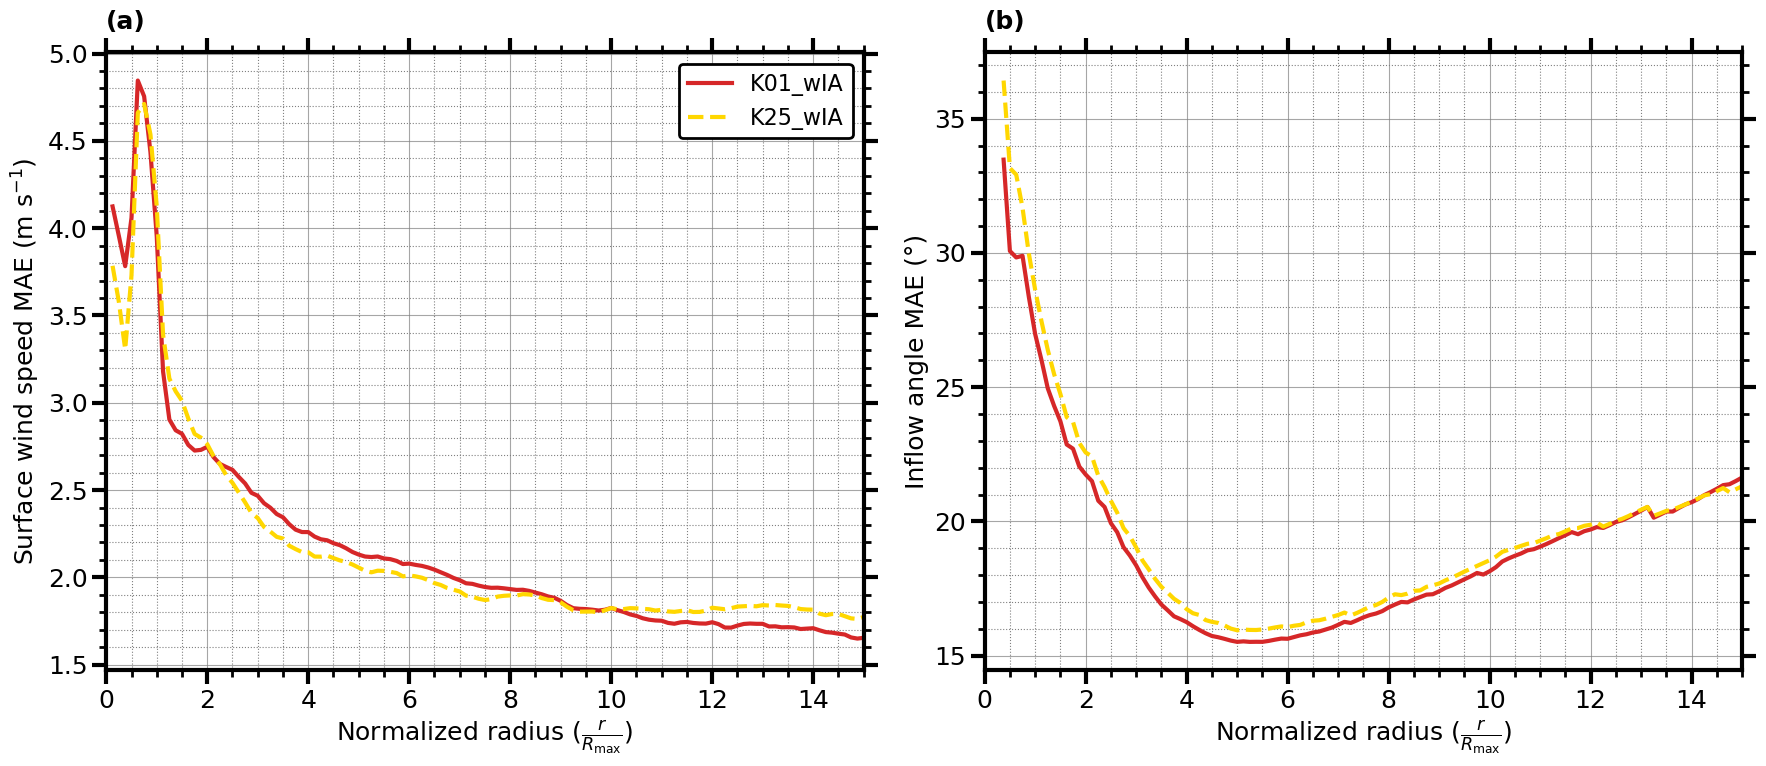

In [48]:
# Create figure with subplots
fig = plt.figure(figsize=(18, 8))
gs  = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

#####################
###   MAE SPEEDS  ###
#####################
ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k01i_), axis=0), linewidth=3, c=c_k01, label='K01_wIA')
ax1.plot(r_star, np.nanmean(abs(arr_spd_diffs_k25i_), axis=0), linewidth=3, c=c_k25, label='K25_wIA', linestyle='dashed')

# Labels
ax1.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax1.set_ylabel('Surface wind speed MAE (m s$^{-1}$)')
ax1.set_xlim(0, 15)
ax1.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Legend
leg = ax1.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)



#####################
###  MAE INF ANG  ###
#####################
ax2.text(0.0, 1.03, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k01i_), axis=0), linewidth=3, c=c_k01, label='K01_wIA')
ax2.plot(r_star, np.nanmean(abs(arr_ia_diffs_k25i_), axis=0), linewidth=3, c=c_k25, label='K25_wIA', linestyle='dashed')

# Labels
ax2.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax2.set_ylabel('Inflow angle MAE (°)')
ax2.set_xlim(0, 15)
ax2.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', color='gray')
ax2.grid(which='minor', linestyle=':', color='gray')
for spine in ax2.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.tick_params(which='major', width=3, length=10, top=True, right=True)
ax2.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_wIA_1D_diagnostics.png', bbox_inches='tight')

### 2) Diagnose winds vs ZU12

#### a) KXX_PRM

In [38]:
### Extract ZU12 and KXX_PRM wind speed differences and interpolate them on r_star
# (about 2 minutes)

### Initialize
listOfIAsZU12        = [] # ZU12
# K01 param
listOfIAs_dsk01_prm  = [] # K01 param
ias_diffs_k01p       = [] # Wind speed diffs,                       
ias_diffs_k01p_      = [] # Wind speed diffs, interp. on r_star                      
# K25 param
listOfIAs_dsk25_prm  = [] # K25 param
ias_diffs_k25p       = [] # Wind speed diffs,                       
ias_diffs_k25p_      = [] # Wind speed diffs, interp. on r_star                       

for path in tqdm(list_of_PRM_paths):
    dsk01_prm         = xr.open_dataset(PTHS['K01_PRM_dir'] + os.path.basename(path)).sel(z=10, theta=slice(0, 359))
    dsk25_prm         = xr.open_dataset(PTHS['K25_PRM_dir'] + os.path.basename(path)).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_prm.file_tcva.item(), drop=True).isel(time=0)
    dszu12            = xr.open_dataset(PTHS['ZU12_dir'] + os.path.basename(path))

    # Add the non-interpolated wind speeds
    ias_diff_k01p     = np.subtract(np.array(dszu12.interp(rad=dsk01_prm.rad).inflow_angle.transpose()), np.array(np.rad2deg(np.arctan(dsk25_prm.rad_wind / abs(dsk25_prm.tan_wind)))))
    ias_diff_k25p     = np.subtract(np.array(dszu12.interp(rad=dsk25_prm.rad).inflow_angle.transpose()), np.array(np.rad2deg(np.arctan(dsk25_prm.rad_wind / abs(dsk25_prm.tan_wind)))))

    # Interpolate on r_star
    dss, dk01p, dk25p = dszu12.copy(deep=True), dsk01_prm.copy(deep=True), dsk25_prm.copy(deep=True)
    dss['rad']        = dss['rad']   / float(ds.rmx)
    dk01p['rad']      = dk01p['rad'] / float(ds.rmx)
    dk25p['rad']      = dk25p['rad'] / float(ds.rmx)
    ias_diff_k01p_    = np.subtract(np.array(dss.inflow_angle.transpose().interp(rad=r_star)), np.rad2deg(np.arctan(dk01p.rad_wind / abs(dk01p.tan_wind))).interp(rad=r_star))
    ias_diff_k25p_    = np.subtract(np.array(dss.inflow_angle.transpose().interp(rad=r_star)), np.rad2deg(np.arctan(dk25p.rad_wind / abs(dk25p.tan_wind))).interp(rad=r_star))

    ### Append
    # SAR
    listOfIAsZU12.append(np.array(dszu12.interp(rad=dsk01_prm.rad).inflow_angle.transpose()).flatten())
    # K01 param
    listOfIAs_dsk01_prm.append(np.array(np.rad2deg(np.arctan(dsk01_prm.rad_wind / abs(dsk01_prm.tan_wind)))).flatten())
    ias_diffs_k01p.append(ias_diff_k01p)
    ias_diffs_k01p_.append(ias_diff_k01p_)
    # K25 param
    listOfIAs_dsk25_prm.append(np.array(np.rad2deg(np.arctan(dsk25_prm.rad_wind / abs(dsk25_prm.tan_wind)))).flatten())
    ias_diffs_k25p.append(ias_diff_k25p)
    ias_diffs_k25p_.append(ias_diff_k25p_)

    # Close
    dsk01_prm.close()
    dsk25_prm.close()
    dszu12.close()
    dss.close()
    dk01p.close()
    dk25p.close()

  0%|          | 0/472 [00:00<?, ?it/s]

In [39]:
### Concatenate the raw inflow angle
ias_zu12            = np.concatenate(listOfIAsZU12)
ias_k01p            = np.concatenate(listOfIAs_dsk01_prm)
ias_k25p            = np.concatenate(listOfIAs_dsk25_prm)

### Concatenate the r_star inflow angle
arr_ias_diffs_k01p_ = np.concatenate(ias_diffs_k01p_)
arr_ias_diffs_k25p_ = np.concatenate(ias_diffs_k25p_)

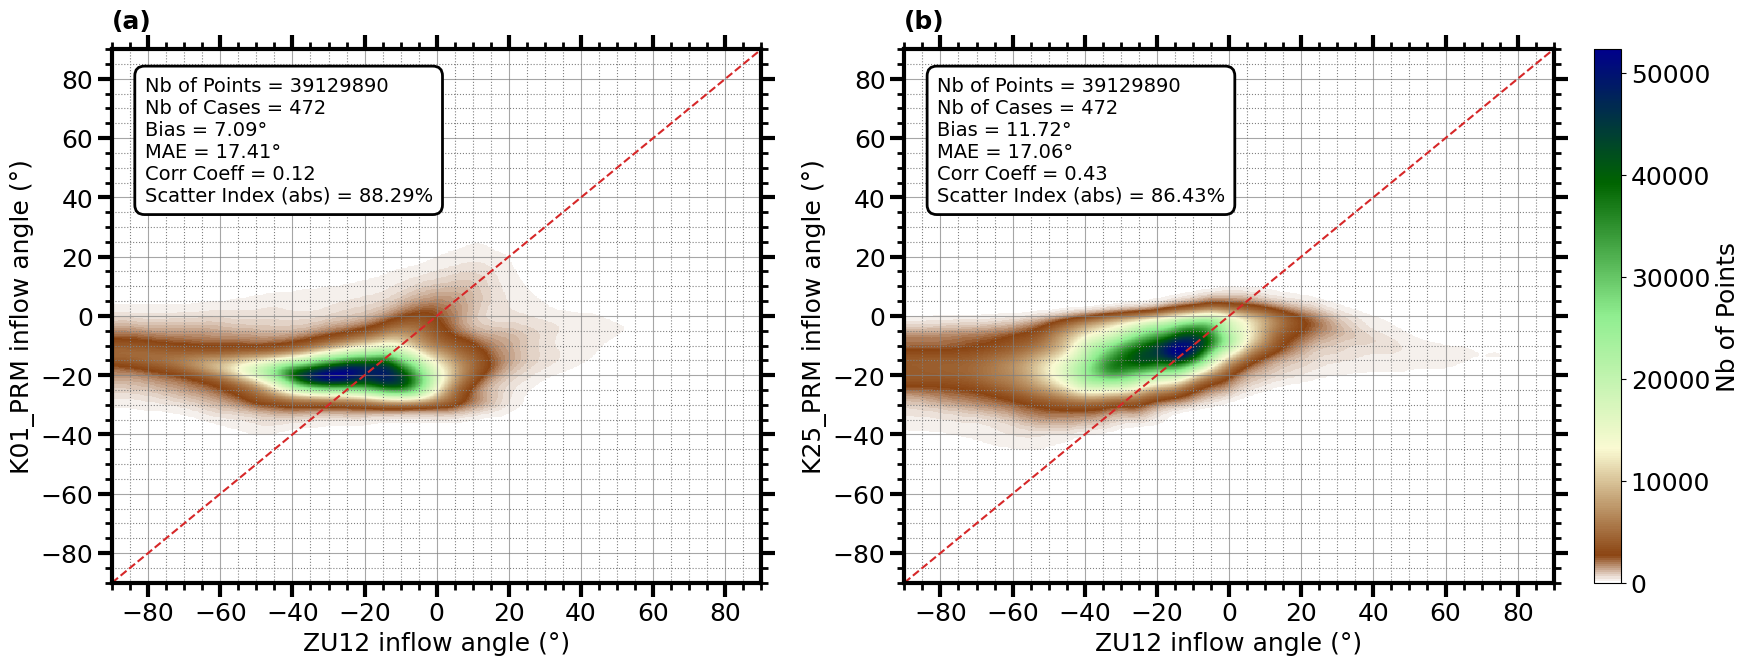

In [40]:
# --- Hyperparameters ---
xbins    = np.linspace(0, 70, 140 + 1)
ybins    = np.linspace(0, 70, 140 + 1)

xbins_ia    = np.linspace(-90, 90, 180 + 1)
ybins_ia    = np.linspace(-90, 90, 180 + 1)
# xbins_ia    = np.linspace(0, 90, 90 + 1)
# ybins_ia    = np.linspace(0, 90, 90 + 1)

ticks_ia    = np.arange(-80, 81, 20)

# Create figure with subplots
fig = plt.figure(figsize=(18, 7))
gs  = GridSpec(1, 2, width_ratios=[1, 1.25])
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, 0])
# ax4 = fig.add_subplot(gs[1, 1])

#####################
###  K01 PRM IA   ###
#####################
ax3.text(0.0, 1.03, '(a)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# ias_sct  = abs(ias_sct)
# ias_k01p = abs(ias_k01p)

# --- Nettoyage des données ---
valid_mask_k01   = ~np.isnan(ias_zu12) & ~np.isnan(ias_k01p)
ias_zu12_cleaned = ias_zu12[valid_mask_k01]
ias_k01p_cleaned = ias_k01p[valid_mask_k01]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_zu12_cleaned,
    ias_k01p_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax3.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax3.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im3, ax=ax3)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax3.set_xlabel(r'ZU12 inflow angle (°)')
ax3.set_ylabel('K01_PRM inflow angle (°)')
ax3.set_xlim(-90, 90); ax3.set_ylim(-90, 90)
ax3.set_xticks(ticks_ia)
ax3.set_yticks(ticks_ia)
ax3.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k01p_cleaned)
n_cases       = np.shape(ias_diffs_k01p_)[0]
differences   = ias_k01p_cleaned - ias_zu12_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_zu12_cleaned, ias_k01p_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_zu12_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax3.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax3.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K25 PRM IA   ###
#####################
ax4.text(0.0, 1.03, '(b)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# ias_sct  = abs(ias_sct)
# ias_k25p = abs(ias_k25p)

# --- Nettoyage des données ---
valid_mask_k25   = ~np.isnan(ias_zu12) & ~np.isnan(ias_k25p)
ias_zu12_cleaned = ias_zu12[valid_mask_k25]
ias_k25p_cleaned = ias_k25p[valid_mask_k25]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_zu12_cleaned,
    ias_k25p_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im3 = ax4.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax4.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im3, ax=ax4)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax4.set_xlabel(r'ZU12 inflow angle (°)')
ax4.set_ylabel('K25_PRM inflow angle (°)')
ax4.set_xlim(-90, 90); ax4.set_ylim(-90, 90)
ax4.set_xticks(ticks_ia)
ax4.set_yticks(ticks_ia)
ax4.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k25p_cleaned)
n_cases       = np.shape(ias_diffs_k25p_)[0]
differences   = ias_k25p_cleaned - ias_zu12_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_zu12_cleaned, ias_k25p_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_zu12_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax4.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax4.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_PRM_2D_diagnostics_ZU12.png', bbox_inches='tight')

/tmp/ipykernel_20602/4145859104.py:12: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k01p_), axis=0), linewidth=3, c=c_k01, label='K01_PRM')
/tmp/ipykernel_20602/4145859104.py:13: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k25p_), axis=0), linewidth=3, c=c_k25, label='K25_PRM', linestyle='dashed')


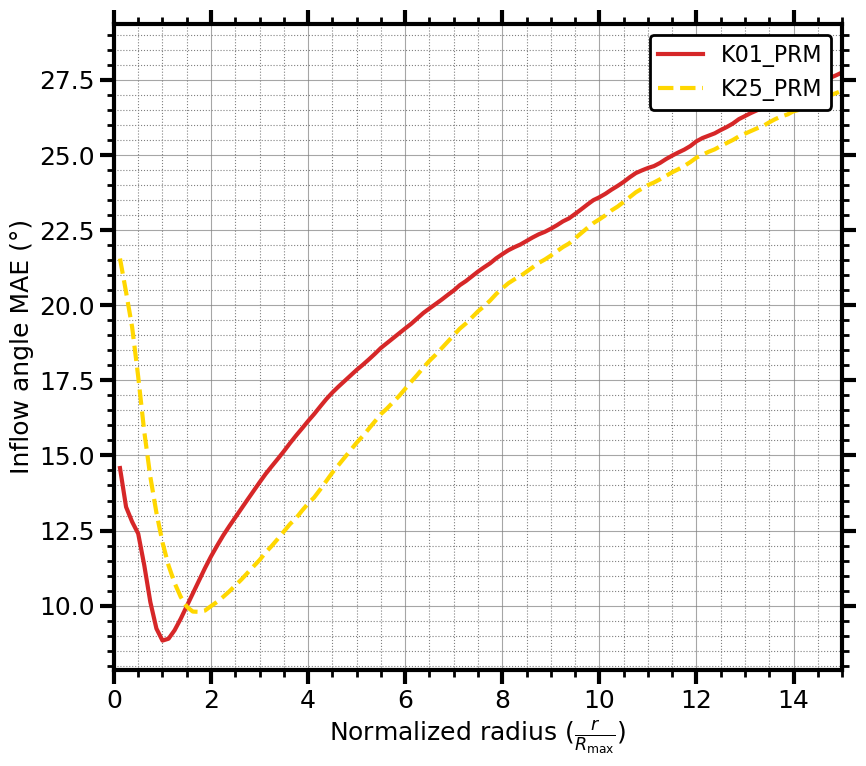

In [41]:
# Create figure with subplots
fig = plt.figure(figsize=(9, 8))
gs  = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])

#####################
###  MAE INF ANG  ###
#####################
# ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k01p_), axis=0), linewidth=3, c=c_k01, label='K01_PRM')
ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k25p_), axis=0), linewidth=3, c=c_k25, label='K25_PRM', linestyle='dashed')

# Labels
ax1.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax1.set_ylabel('Inflow angle MAE (°)')
ax1.set_xlim(0, 15)
ax1.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Legend
leg = ax1.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_PRM_1D_diagnostics_ZU12.png', bbox_inches='tight')

#### b) KXX_FIT

In [41]:
### Extract ZU12 and KXX_FIT wind speed differences and interpolate them on r_star
# (about 2 minutes)

### Initialize
listOfIAs_ZU12_k01f  = [] # ZU12
listOfIAs_ZU12_k25f  = [] # ZU12
# K01
listOfIAs_dsk01_fit  = [] # K01 param
ias_diffs_k01f       = [] # Wind speed diffs,                       
ias_diffs_k01f_      = [] # Wind speed diffs, interp. on r_star                      
# K25
listOfIAs_dsk25_fit  = [] # K25 param
ias_diffs_k25f       = [] # Wind speed diffs,                       
ias_diffs_k25f_      = [] # Wind speed diffs, interp. on r_star                       

# K01
for file in tqdm(dk01_clean.dropna(dim='time', subset=['vmx']).file_tcva):
    dsk01_fit         = xr.open_dataset(PTHS['K01_FIT_dir'] + '{}.nc'.format(file.item()[:-17])).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_fit.file_tcva.item(), drop=True).isel(time=0)
    dszu12            = xr.open_dataset(PTHS['ZU12_dir'] + '{}.nc'.format(file.item()[:-17]))

    # Add the non-interpolated inflow angle
    ias_diff_k01f     = np.subtract(np.array(dszu12.interp(rad=dsk01_fit.rad, theta=dsk01_fit.theta).inflow_angle.transpose()), np.array(np.rad2deg(np.arctan(dsk01_fit.rad_wind / abs(dsk01_fit.tan_wind)))))

    # Interpolate on r_star
    dss, dk01f        = dszu12.copy(deep=True), dsk01_fit.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk01f['rad']      = dk01f['rad'] / float(ds.rmx)
    ias_diff_k01f_    = np.subtract(np.array(dss.inflow_angle.transpose().interp(rad=r_star, theta=dsk01_fit.theta)), np.rad2deg(np.arctan(dk01f.rad_wind / abs(dk01f.tan_wind))).interp(rad=r_star))
    
    ### Append
    # ZU12
    listOfIAs_ZU12_k01f.append(np.array(dszu12.interp(rad=dsk01_fit.rad, theta=dsk01_fit.theta).inflow_angle.transpose()).flatten())
    # K01 fit
    listOfIAs_dsk01_fit.append(np.array(np.rad2deg(np.arctan(dsk01_fit.rad_wind / abs(dsk01_fit.tan_wind)))).flatten())
    ias_diffs_k01f.append(ias_diff_k01f)
    ias_diffs_k01f_.append(ias_diff_k01f_)

    # Close
    dszu12.close()
    dsk01_fit.close()
    dss.close()
    dk01f.close()

# K25
for file in tqdm(dk25_clean.dropna(dim='time', subset=['vmx']).file_tcva):
    dsk25_fit         = xr.open_dataset(PTHS['K25_FIT_dir'] + '{}.nc'.format(file.item()[:-17])).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk25_fit.file_tcva.item(), drop=True).isel(time=0)
    dszu12            = xr.open_dataset(PTHS['ZU12_dir'] + '{}.nc'.format(file.item()[:-17]))

    # Add the non-interpolated inflow angle
    ias_diff_k25f     = np.subtract(np.array(dszu12.interp(rad=dsk25_fit.rad, theta=dsk25_fit.theta).inflow_angle.transpose()), np.array(np.rad2deg(np.arctan(dsk25_fit.rad_wind / abs(dsk25_fit.tan_wind)))))

    # Interpolate on r_star
    dss, dk25f        = dszu12.copy(deep=True), dsk25_fit.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk25f['rad']      = dk25f['rad'] / float(ds.rmx)
    ias_diff_k25f_    = np.subtract(np.array(dss.inflow_angle.transpose().interp(rad=r_star, theta=dsk25_fit.theta)), np.rad2deg(np.arctan(dk25f.rad_wind / abs(dk25f.tan_wind))).interp(rad=r_star))
    
    ### Append
    # ZU12
    listOfIAs_ZU12_k25f.append(np.array(dszu12.interp(rad=dsk25_fit.rad, theta=dsk25_fit.theta).inflow_angle.transpose()).flatten())
    # K25 fit
    listOfIAs_dsk25_fit.append(np.array(np.rad2deg(np.arctan(dsk25_fit.rad_wind / abs(dsk25_fit.tan_wind)))).flatten())
    ias_diffs_k25f.append(ias_diff_k25f)
    ias_diffs_k25f_.append(ias_diff_k25f_)

    # Close
    dszu12.close()
    dsk25_fit.close()
    dss.close()
    dk25f.close()

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

In [42]:
### Concatenate the raw inflow angle
ias_zu12_k01f       = np.concatenate(listOfIAs_ZU12_k01f)
ias_zu12_k25f       = np.concatenate(listOfIAs_ZU12_k25f)
ias_k01f            = np.concatenate(listOfIAs_dsk01_fit)
ias_k25f            = np.concatenate(listOfIAs_dsk25_fit)

### Concatenate the r_star inflow angle
arr_ias_diffs_k01f_ = np.concatenate(ias_diffs_k01f_)
arr_ias_diffs_k25f_ = np.concatenate(ias_diffs_k25f_)

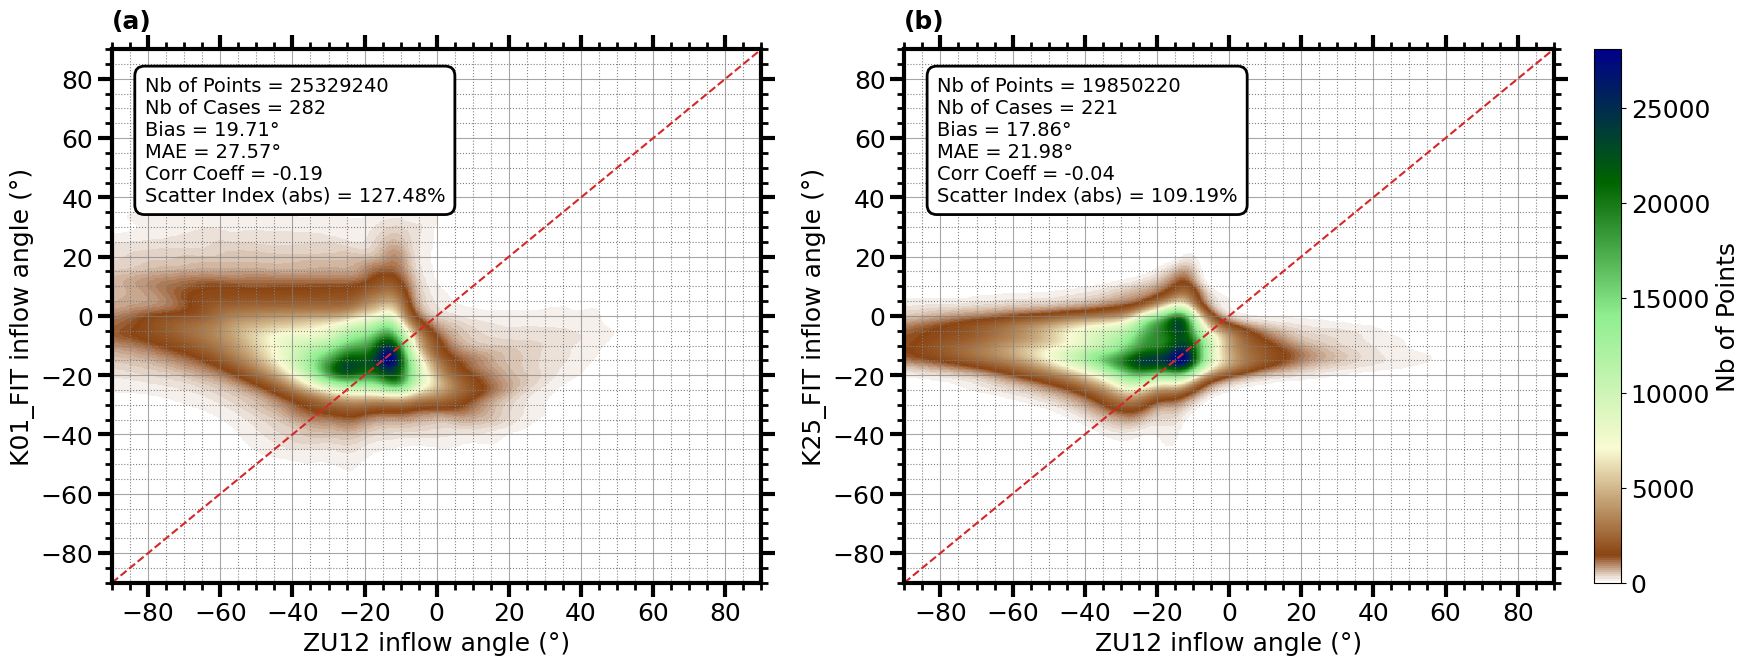

In [43]:
# --- Hyperparameters ---
xbins    = np.linspace(0, 70, 140 + 1)
ybins    = np.linspace(0, 70, 140 + 1)

xbins_ia    = np.linspace(-90, 90, 180 + 1)
ybins_ia    = np.linspace(-90, 90, 180 + 1)
# xbins_ia    = np.linspace(0, 90, 90 + 1)
# ybins_ia    = np.linspace(0, 90, 90 + 1)

ticks_ia    = np.arange(-80, 81, 20)

# Create figure with subplots
fig = plt.figure(figsize=(18, 7))
gs  = GridSpec(1, 2, width_ratios=[1, 1.25])
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, 0])
# ax4 = fig.add_subplot(gs[1, 1])

#####################
###  K01 PRM IA   ###
#####################
ax3.text(0.0, 1.03, '(a)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# ias_sct  = abs(ias_sct)
# ias_k01p = abs(ias_k01p)

# --- Nettoyage des données ---
valid_mask_k01   = ~np.isnan(ias_zu12_k01f) & ~np.isnan(ias_k01f)
ias_zu12_cleaned = ias_zu12_k01f[valid_mask_k01]
ias_k01f_cleaned = ias_k01f[valid_mask_k01]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_zu12_cleaned,
    ias_k01f_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax3.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax3.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im3, ax=ax3)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax3.set_xlabel(r'ZU12 inflow angle (°)')
ax3.set_ylabel('K01_FIT inflow angle (°)')
ax3.set_xlim(-90, 90); ax3.set_ylim(-90, 90)
ax3.set_xticks(ticks_ia)
ax3.set_yticks(ticks_ia)
ax3.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k01f_cleaned)
n_cases       = np.shape(ias_diffs_k01f_)[0]
differences   = ias_k01f_cleaned - ias_zu12_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_zu12_cleaned, ias_k01f_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_zu12_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax3.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax3.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K25 PRM IA   ###
#####################
ax4.text(0.0, 1.03, '(b)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# ias_sct  = abs(ias_sct)
# ias_k25p = abs(ias_k25p)

# --- Nettoyage des données ---
valid_mask_k25   = ~np.isnan(ias_zu12_k25f) & ~np.isnan(ias_k25f)
ias_zu12_cleaned = ias_zu12_k25f[valid_mask_k25]
ias_k25f_cleaned = ias_k25f[valid_mask_k25]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_zu12_cleaned,
    ias_k25f_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im3 = ax4.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax4.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im3, ax=ax4)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax4.set_xlabel(r'ZU12 inflow angle (°)')
ax4.set_ylabel('K25_FIT inflow angle (°)')
ax4.set_xlim(-90, 90); ax4.set_ylim(-90, 90)
ax4.set_xticks(ticks_ia)
ax4.set_yticks(ticks_ia)
ax4.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k25f_cleaned)
n_cases       = np.shape(ias_diffs_k25f_)[0]
differences   = ias_k25f_cleaned - ias_zu12_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_zu12_cleaned, ias_k25f_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_zu12_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax4.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax4.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)


# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_FIT_2D_diagnostics_ZU12.png', bbox_inches='tight')

/tmp/ipykernel_82368/1270246622.py:12: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k01f_), axis=0), linewidth=3, c=c_k01, label='K01_FIT')
/tmp/ipykernel_82368/1270246622.py:13: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k25f_), axis=0), linewidth=3, c=c_k25, label='K25_FIT', linestyle='dashed')


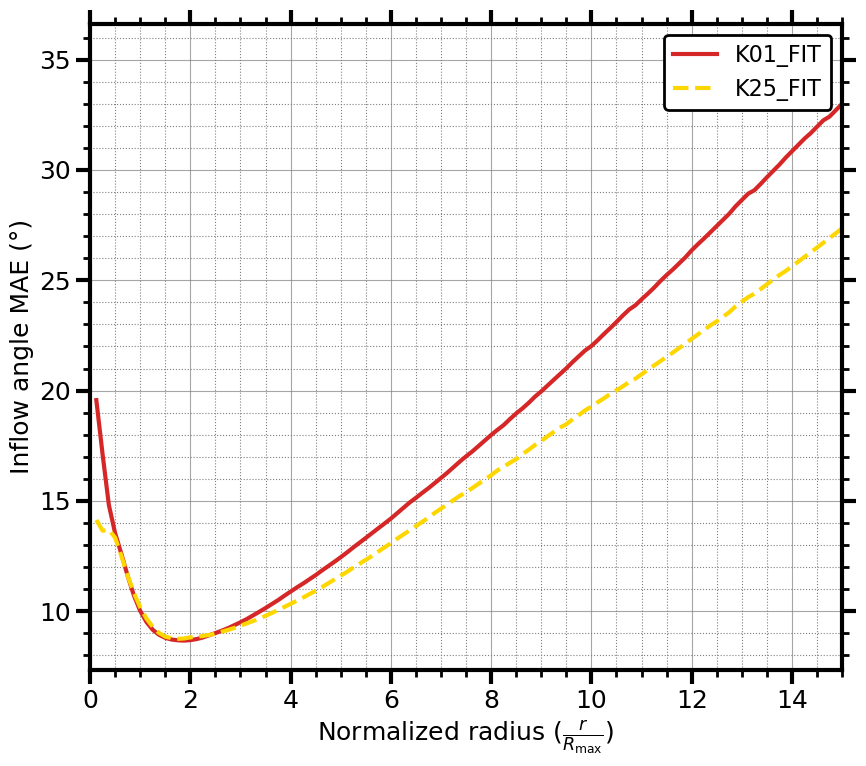

In [44]:
# Create figure with subplots
fig = plt.figure(figsize=(9, 8))
gs  = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])

#####################
###  MAE INF ANG  ###
#####################
# ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k01f_), axis=0), linewidth=3, c=c_k01, label='K01_FIT')
ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k25f_), axis=0), linewidth=3, c=c_k25, label='K25_FIT', linestyle='dashed')

# Labels
ax1.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax1.set_ylabel('Inflow angle MAE (°)')
ax1.set_xlim(0, 15)
ax1.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Legend
leg = ax1.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_FIT_1D_diagnostics_ZU12.png', bbox_inches='tight')

#### c) KXX_wIA

In [45]:
### Extract ZU12 and KXX_wIA wind speed differences and interpolate them on r_star
# (about 2 minutes)

### Initialize
listOfIAs_ZU12_k01i  = [] # ZU12
listOfIAs_ZU12_k25i  = [] # ZU12
# K01
listOfIAs_dsk01_wIA  = [] # K01 wIA
ias_diffs_k01i       = [] # Wind speed diffs,                       
ias_diffs_k01i_      = [] # Wind speed diffs, interp. on r_star                      
# K25
listOfIAs_dsk25_wIA  = [] # K25 wIA
ias_diffs_k25i       = [] # Wind speed diffs,                       
ias_diffs_k25i_      = [] # Wind speed diffs, interp. on r_star                       

# K01
for file in tqdm(dk01i_clean.dropna(dim='time', subset=['vmx']).file_tcva):
    dsk01_wIA         = xr.open_dataset(PTHS['K01_wIA_dir'] + '{}.nc'.format(file.item()[:-17])).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_wIA.file_tcva.item(), drop=True).isel(time=0)
    dszu12            = xr.open_dataset(PTHS['ZU12_dir'] + '{}.nc'.format(file.item()[:-17]))

    # Add the non-interpolated inflow angle
    ias_diff_k01i     = np.subtract(np.array(dszu12.interp(rad=dsk01_wIA.rad, theta=dsk01_wIA.theta).inflow_angle.transpose()), np.array(np.rad2deg(np.arctan(dsk01_wIA.rad_wind / abs(dsk01_wIA.tan_wind)))))

    # Interpolate on r_star
    dss, dk01i        = dszu12.copy(deep=True), dsk01_wIA.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk01i['rad']      = dk01i['rad'] / float(ds.rmx)
    ias_diff_k01i_    = np.subtract(np.array(dss.inflow_angle.transpose().interp(rad=r_star, theta=dsk01_wIA.theta)), np.rad2deg(np.arctan(dk01i.rad_wind / abs(dk01i.tan_wind))).interp(rad=r_star))
    
    ### Append
    # ZU12
    listOfIAs_ZU12_k01i.append(np.array(dszu12.interp(rad=dsk01_wIA.rad, theta=dsk01_wIA.theta).inflow_angle.transpose()).flatten())
    # K01 fit
    listOfIAs_dsk01_wIA.append(np.array(np.rad2deg(np.arctan(dsk01_wIA.rad_wind / abs(dsk01_wIA.tan_wind)))).flatten())
    ias_diffs_k01i.append(ias_diff_k01i)
    ias_diffs_k01i_.append(ias_diff_k01i_)

    # Close
    dszu12.close()
    dsk01_wIA.close()
    dss.close()
    dk01i.close()

# K25
for file in tqdm(dk25i_clean.dropna(dim='time', subset=['vmx']).file_tcva):
    dsk25_wIA         = xr.open_dataset(PTHS['K25_wIA_dir'] + '{}.nc'.format(file.item()[:-17])).sel(z=10, theta=slice(0, 359))
    ds                = dsg_filtered.where(dsg_filtered.file_tcva == dsk25_wIA.file_tcva.item(), drop=True).isel(time=0)
    dszu12            = xr.open_dataset(PTHS['ZU12_dir'] + '{}.nc'.format(file.item()[:-17]))

    # Add the non-interpolated inflow angle
    ias_diff_k25i     = np.subtract(np.array(dszu12.interp(rad=dsk25_wIA.rad, theta=dsk25_wIA.theta).inflow_angle.transpose()), np.array(np.rad2deg(np.arctan(dsk25_wIA.rad_wind / abs(dsk25_wIA.tan_wind)))))

    # Interpolate on r_star
    dss, dk25i        = dszu12.copy(deep=True), dsk25_wIA.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk25i['rad']      = dk25i['rad'] / float(ds.rmx)
    ias_diff_k25i_    = np.subtract(np.array(dss.inflow_angle.transpose().interp(rad=r_star, theta=dsk25_wIA.theta)), np.rad2deg(np.arctan(dk25i.rad_wind / abs(dk25i.tan_wind))).interp(rad=r_star))
    
    ### Append
    # ZU12
    listOfIAs_ZU12_k25i.append(np.array(dszu12.interp(rad=dsk25_wIA.rad, theta=dsk25_wIA.theta).inflow_angle.transpose()).flatten())
    # K25 fit
    listOfIAs_dsk25_wIA.append(np.array(np.rad2deg(np.arctan(dsk25_wIA.rad_wind / abs(dsk25_wIA.tan_wind)))).flatten())
    ias_diffs_k25i.append(ias_diff_k25i)
    ias_diffs_k25i_.append(ias_diff_k25i_)

    # Close
    dszu12.close()
    dsk25_wIA.close()
    dss.close()
    dk25i.close()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

In [46]:
### Concatenate the raw inflow angle
ias_zu12_k01i       = np.concatenate(listOfIAs_ZU12_k01i)
ias_zu12_k25i       = np.concatenate(listOfIAs_ZU12_k25i)
ias_k01i            = np.concatenate(listOfIAs_dsk01_wIA)
ias_k25i            = np.concatenate(listOfIAs_dsk25_wIA)

### Concatenate the r_star inflow angle
arr_ias_diffs_k01i_ = np.concatenate(ias_diffs_k01i_)
arr_ias_diffs_k25i_ = np.concatenate(ias_diffs_k25i_)

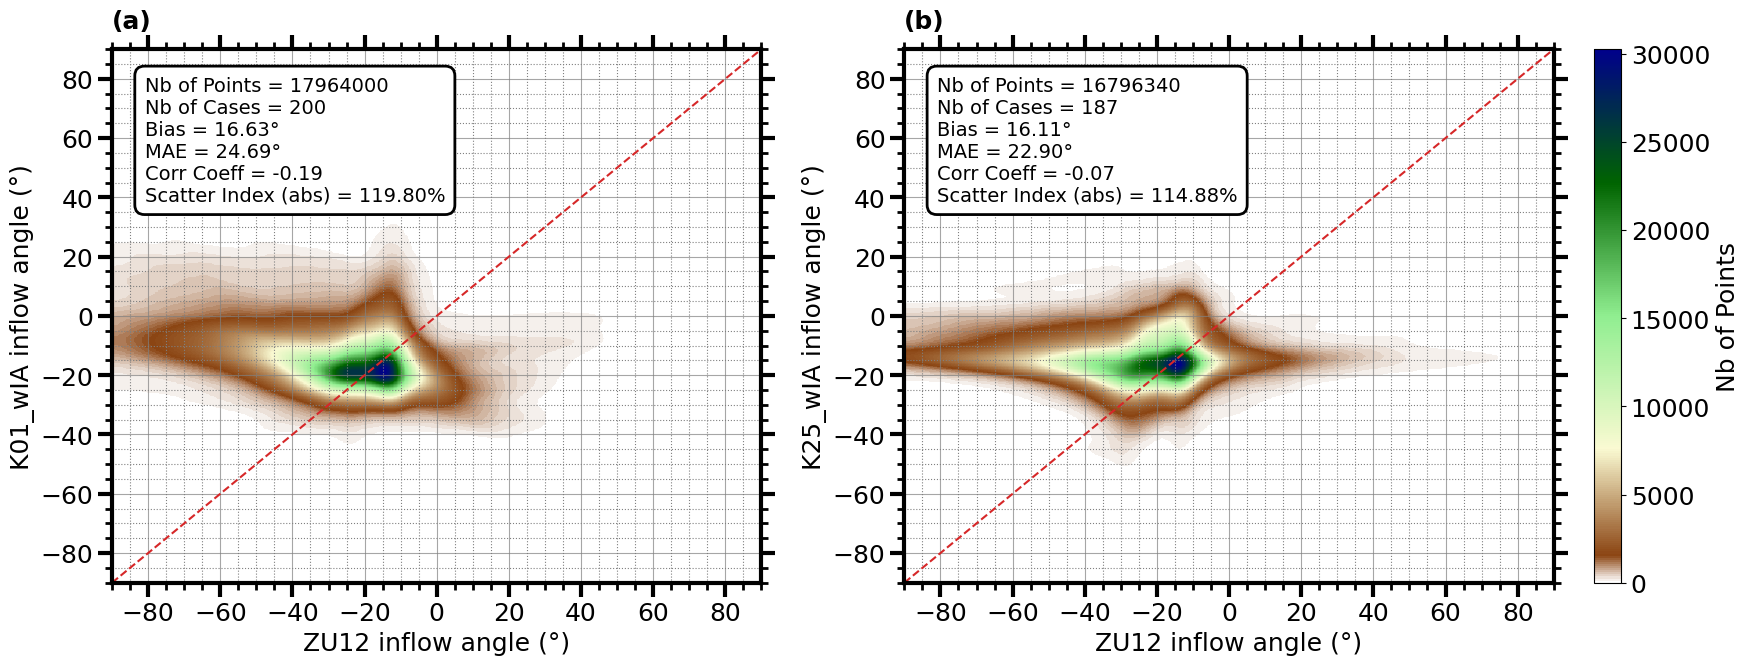

In [47]:
# --- Hyperparameters ---
xbins    = np.linspace(0, 70, 140 + 1)
ybins    = np.linspace(0, 70, 140 + 1)

xbins_ia    = np.linspace(-90, 90, 180 + 1)
ybins_ia    = np.linspace(-90, 90, 180 + 1)
# xbins_ia    = np.linspace(0, 90, 90 + 1)
# ybins_ia    = np.linspace(0, 90, 90 + 1)

ticks_ia    = np.arange(-80, 81, 20)

# Create figure with subplots
fig = plt.figure(figsize=(18, 7))
gs  = GridSpec(1, 2, width_ratios=[1, 1.25])
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, 0])
# ax4 = fig.add_subplot(gs[1, 1])

#####################
###  K01 PRM IA   ###
#####################
ax3.text(0.0, 1.03, '(a)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# ias_sct  = abs(ias_sct)
# ias_k01p = abs(ias_k01p)

# --- Nettoyage des données ---
valid_mask_k01   = ~np.isnan(ias_zu12_k01i) & ~np.isnan(ias_k01i)
ias_zu12_cleaned = ias_zu12_k01i[valid_mask_k01]
ias_k01i_cleaned = ias_k01i[valid_mask_k01]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_zu12_cleaned,
    ias_k01i_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax3.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax3.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im3, ax=ax3)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax3.set_xlabel(r'ZU12 inflow angle (°)')
ax3.set_ylabel('K01_wIA inflow angle (°)')
ax3.set_xlim(-90, 90); ax3.set_ylim(-90, 90)
ax3.set_xticks(ticks_ia)
ax3.set_yticks(ticks_ia)
ax3.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k01i_cleaned)
n_cases       = np.shape(ias_diffs_k01i_)[0]
differences   = ias_k01i_cleaned - ias_zu12_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_zu12_cleaned, ias_k01i_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_zu12_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax3.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax3.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)



#####################
###  K25 PRM IA   ###
#####################
ax4.text(0.0, 1.03, '(b)', transform=ax4.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# ias_sct  = abs(ias_sct)
# ias_k25p = abs(ias_k25p)

# --- Nettoyage des données ---
valid_mask_k25   = ~np.isnan(ias_zu12_k25i) & ~np.isnan(ias_k25i)
ias_zu12_cleaned = ias_zu12_k25i[valid_mask_k25]
ias_k25i_cleaned = ias_k25i[valid_mask_k25]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_zu12_cleaned,
    ias_k25i_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im3 = ax4.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax4.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

cbar = plt.colorbar(im3, ax=ax4)
cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax4.set_xlabel(r'ZU12 inflow angle (°)')
ax4.set_ylabel('K25_wIA inflow angle (°)')
ax4.set_xlim(-90, 90); ax4.set_ylim(-90, 90)
ax4.set_xticks(ticks_ia)
ax4.set_yticks(ticks_ia)
ax4.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_k25i_cleaned)
n_cases       = np.shape(ias_diffs_k25i_)[0]
differences   = ias_k25i_cleaned - ias_zu12_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_zu12_cleaned, ias_k25i_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_zu12_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax4.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax4.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax4.minorticks_on()
ax4.grid(which='major', linestyle='-', color='gray')
ax4.grid(which='minor', linestyle=':', color='gray')
for spine in ax4.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax4.spines['right'].set_visible(True)
ax4.spines['top'].set_visible(True)
ax4.tick_params(which='major', width=3, length=10, top=True, right=True)
ax4.tick_params(which='minor', width=2, length=5, top=True, right=True)


# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_wIA_2D_diagnostics_ZU12.png', bbox_inches='tight')

/tmp/ipykernel_82368/964840860.py:12: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k01i_), axis=0), linewidth=3, c=c_k01, label='K01_wIA')
/tmp/ipykernel_82368/964840860.py:13: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k25i_), axis=0), linewidth=3, c=c_k25, label='K25_wIA', linestyle='dashed')


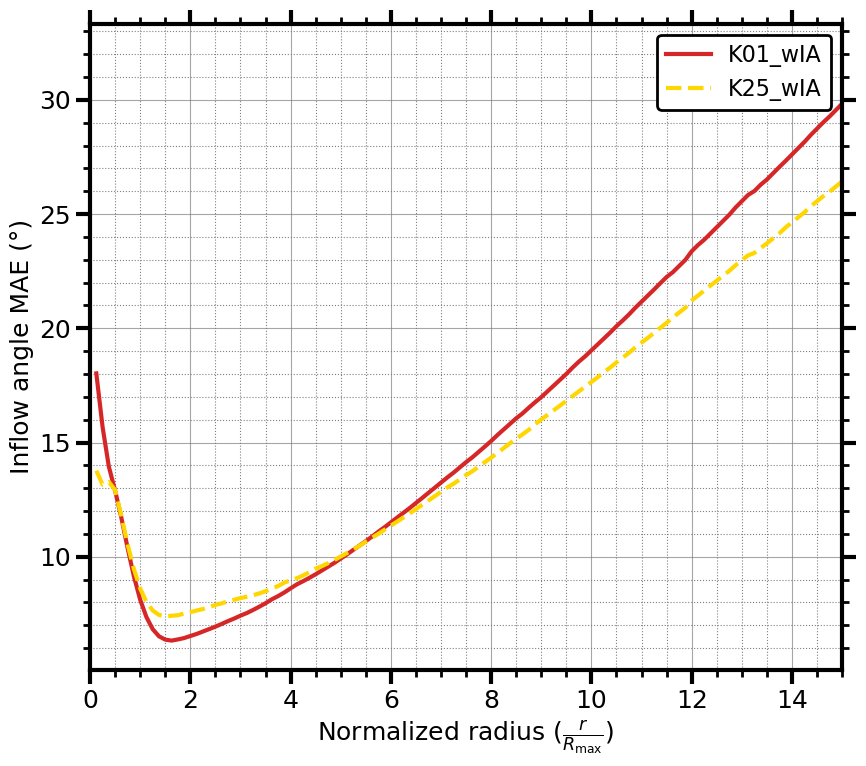

In [48]:
# Create figure with subplots
fig = plt.figure(figsize=(9, 8))
gs  = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])

#####################
###  MAE INF ANG  ###
#####################
# ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k01i_), axis=0), linewidth=3, c=c_k01, label='K01_wIA')
ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_k25i_), axis=0), linewidth=3, c=c_k25, label='K25_wIA', linestyle='dashed')

# Labels
ax1.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax1.set_ylabel('Inflow angle MAE (°)')
ax1.set_xlim(0, 15)
ax1.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Legend
leg = ax1.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'KXX_wIA_1D_diagnostics_ZU12.png', bbox_inches='tight')

### 3) Diagnose SCAT vs ZU12/SAR

First we need to collocate SAR and SCAT, because to apply ZU12, we need SAR.

In [37]:
# For debug, use t = 90

# Initialize
list_of_collocated_sct_pths = []
list_of_collocated_sar_fles = []

# Iterate
for t in tqdm(range(len(dsg_filtered.time))):
    ### Open SAR
    ds         = dsg_filtered.isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths.append(matching_path)
            list_of_collocated_sar_fles.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    # ds.close()
    ### Open models
    # dsp        = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    # dsk_prm    = xr.open_dataset(PTHS['K01_PRM_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10, theta=slice(0, 359))
    # dsk_fit    = xr.open_dataset(PTHS['K01_FIT_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10).interp(theta=np.array(dsp.theta))

print(len(list_of_collocated_sct_pths))

  0%|          | 0/472 [00:00<?, ?it/s]

364


In [38]:
# Check for duplicates
has_duplicates = len(list_of_collocated_sar_fles) != len(set(list_of_collocated_sar_fles))
if has_duplicates:
    print("La liste contient des doublons.")
else:
    print("La liste ne contient pas de doublons.")

La liste contient des doublons.


In [57]:
### Initialize
listOfIAs_ZU12i     = [] # ZU12
# SCAT
listOfIAs_dssct     = [] # SCAT
ias_diffs_sct       = [] # Wind speed diffs,                       
ias_diffs_sct_      = [] # Wind speed diffs, interp. on r_star                                           

# SCAT
for file_tcva, file_sct in tqdm(zip(list_of_collocated_sar_fles, list_of_collocated_sct_pths)):
    ### Open
    ds     = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva, drop=True)
    ds_sct = xr.open_dataset(file_sct)
    dszu12 = xr.open_dataset(PTHS['ZU12_dir'] + '{}.nc'.format(file_tcva[:-17]))

    # Add the non-interpolated inflow angle
    ia_diffs_sct     = np.subtract(np.array(dszu12.interp(rad=ds_sct.rad, theta=ds_sct.theta).inflow_angle.transpose()), np.array(np.rad2deg(np.arctan(ds_sct.radial_wind / abs(ds_sct.tangential_wind)))))

    # Interpolate on r_star
    dss, dsct        = dszu12.copy(deep=True), ds_sct.copy(deep=True)
    dss['rad']       = dss['rad'] / float(ds.rmx)
    dsct['rad']      = dsct['rad'] / float(ds.rmx)
    ia_diffs_sct_    = np.subtract(np.array(dss.inflow_angle.transpose().interp(rad=r_star, theta=ds_sct.theta)), np.rad2deg(np.arctan(dsct.radial_wind / abs(dsct.tangential_wind))).interp(rad=r_star))
    
    ### Append
    # ZU12
    listOfIAs_ZU12i.append(np.array(dszu12.interp(rad=ds_sct.rad, theta=ds_sct.theta).inflow_angle.transpose()).flatten())
    # K01 fit
    listOfIAs_dssct.append(np.array(np.rad2deg(np.arctan(ds_sct.radial_wind / abs(ds_sct.tangential_wind)))).flatten())
    ias_diffs_sct.append(ia_diffs_sct)
    ias_diffs_sct_.append(ia_diffs_sct_)

    # Close
    ds_sct.close()
    dss.close()
    dsct.close()
    dszu12.close()

0it [00:00, ?it/s]

In [58]:
### Concatenate the raw inflow angle
ias_zu12       = np.concatenate(listOfIAs_ZU12i)
ias_sct        = np.concatenate(listOfIAs_dssct)

### Concatenate the r_star inflow angle
arr_ias_diffs_sct_  = np.concatenate(ias_diffs_sct_)

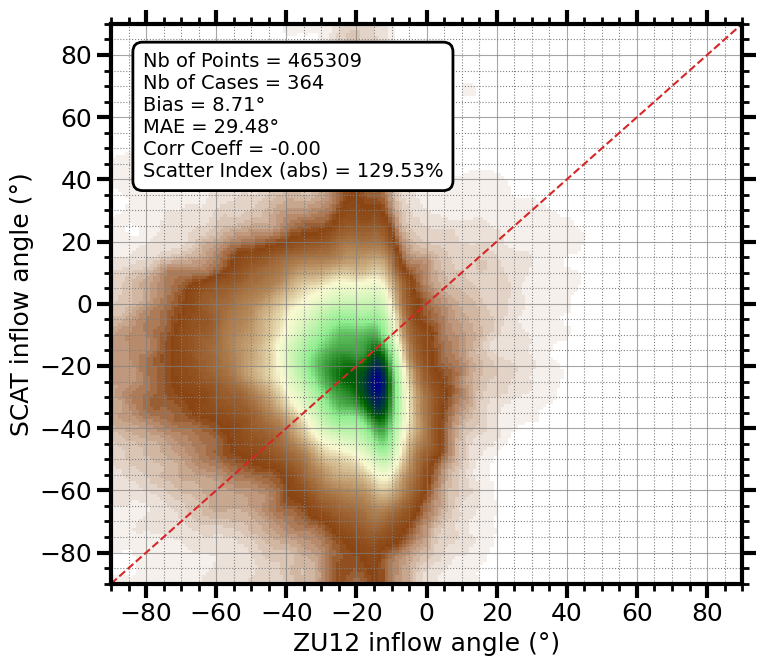

In [59]:
# --- Hyperparameters ---
xbins    = np.linspace(0, 70, 140 + 1)
ybins    = np.linspace(0, 70, 140 + 1)

xbins_ia    = np.linspace(-90, 90, 180 + 1)
ybins_ia    = np.linspace(-90, 90, 180 + 1)
# xbins_ia    = np.linspace(0, 90, 90 + 1)
# ybins_ia    = np.linspace(0, 90, 90 + 1)

ticks_ia    = np.arange(-80, 81, 20)

# Create figure with subplots
fig = plt.figure(figsize=(8, 7))
gs  = GridSpec(1, 1)
ax3 = fig.add_subplot(gs[0, 0])
# ax4 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, 0])
# ax4 = fig.add_subplot(gs[1, 1])

#####################
###  K01 PRM IA   ###
#####################
# ax3.text(0.0, 1.03, '(a)', transform=ax3.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# --- Nettoyage des données ---
valid_mask_k01   = ~np.isnan(ias_zu12) & ~np.isnan(ias_sct)
ias_zu12_cleaned = ias_zu12[valid_mask_k01]
ias_sct_cleaned  = ias_sct[valid_mask_k01]

# --- Calcul de l'histogramme 2D (binning) ---
H, xedges, yedges = np.histogram2d(
    ias_zu12_cleaned,
    ias_sct_cleaned,
    bins=[xbins_ia, ybins_ia]
)
sigma_smoothing = 2
H_smoothed      = gaussian_filter(H, sigma=sigma_smoothing)

# --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
im1 = ax3.imshow(H_smoothed.T,
           origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=custom_cmap,
           aspect='auto')
ax3.plot([-90, 90], [-90, 90], c='tab:red', linestyle='dashed')

# cbar = plt.colorbar(im3, ax=ax3)
# cbar.set_label('Nb of Points')

# plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
ax3.set_xlabel(r'ZU12 inflow angle (°)')
ax3.set_ylabel('SCAT inflow angle (°)')
ax3.set_xlim(-90, 90); ax3.set_ylim(-90, 90)
ax3.set_xticks(ticks_ia)
ax3.set_yticks(ticks_ia)
ax3.grid(True, linestyle='--', alpha=0.7)

# --- Calcul des statistiques ---
n_points      = len(ias_sct_cleaned)
n_cases       = len(ias_diffs_sct_)
differences   = ias_sct_cleaned - ias_zu12_cleaned
bias          = np.mean(differences)
mae           = abs(differences).mean()
rmse          = np.sqrt(((differences) ** 2).mean())
# std_dev       = np.std(differences)
correlation   = np.corrcoef(ias_zu12_cleaned, ias_sct_cleaned)[0, 1]
mean_dsc      = np.mean(abs(ias_zu12_cleaned))
scatter_index = (rmse / mean_dsc) * 100

stats_text = (f"Nb of Points = {n_points}\n"
              f"Nb of Cases = {n_cases}\n"
              # f"Bias = {bias:.2f}\n"
              f"Bias = {bias:.2f}{r"°"}\n"
              f"MAE = {mae:.2f}{r"°"}\n"
              f"Corr Coeff = {correlation:.2f}\n"
              f"Scatter Index (abs) = {scatter_index:.2f}%")

# --- Modification pour placer l'encart en haut à gauche ---
ax3.text(0.05, 0.95, stats_text, # Changement des coordonnées x
         transform=ax3.transAxes,
         fontsize=14,
         verticalalignment='top',
         horizontalalignment='left', # Changement de l'alignement horizontal
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1.0, ec='black', lw=2.0))

ax3.minorticks_on()
ax3.grid(which='major', linestyle='-', color='gray')
ax3.grid(which='minor', linestyle=':', color='gray')
for spine in ax3.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax3.spines['right'].set_visible(True)
ax3.spines['top'].set_visible(True)
ax3.tick_params(which='major', width=3, length=10, top=True, right=True)
ax3.tick_params(which='minor', width=2, length=5, top=True, right=True)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'SCT_2D_diagnostics_ZU12.png', bbox_inches='tight')

/tmp/ipykernel_84637/823107773.py:12: RuntimeWarning: Mean of empty slice
  ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_sct_), axis=0), linewidth=3, c=c_k01, label='ZU12 vs SCT')


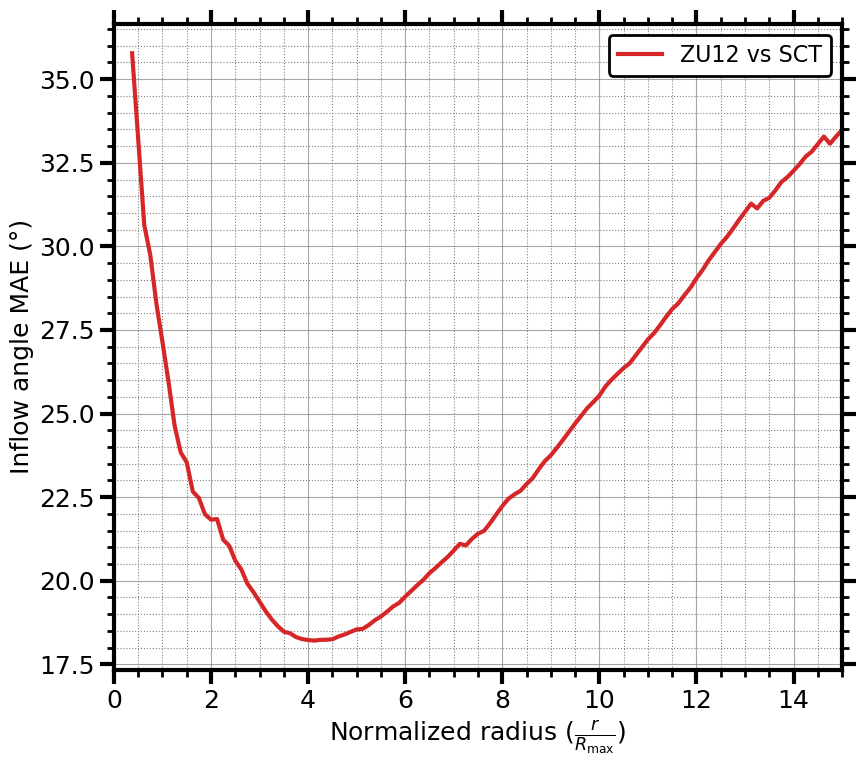

In [60]:
# Create figure with subplots
fig = plt.figure(figsize=(9, 8))
gs  = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])

#####################
###  MAE INF ANG  ###
#####################
# ax1.text(0.0, 1.03, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

# MAE
ax1.plot(r_star, np.nanmean(abs(arr_ias_diffs_sct_), axis=0), linewidth=3, c=c_k01, label='ZU12 vs SCT')

# Labels
ax1.set_xlabel(r'Normalized radius ($\frac{r}{R_{\text{max}}}$)')
ax1.set_ylabel('Inflow angle MAE (°)')
ax1.set_xlim(0, 15)
ax1.grid(True, linestyle='--', alpha=0.7)

# Ticks
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', color='gray')
ax1.grid(which='minor', linestyle=':', color='gray')
for spine in ax1.spines.values():
    spine.set_linewidth(3)
    spine.set_edgecolor('black')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.tick_params(which='major', width=3, length=10, top=True, right=True)
ax1.tick_params(which='minor', width=2, length=5, top=True, right=True)

# Legend
leg = ax1.legend(
    loc='upper right',
    frameon=True,          # Turn the frame back ON
    fancybox=True,         # True = Rounded corners, False = Square corners
    framealpha=1.0,        # 1.0 = Opaque background (hides gridlines behind legend)
    edgecolor='black',     # Border color
    fontsize=16            # Ensure text is readable
)
leg.get_frame().set_linewidth(2.0)



# Final adjustments
plt.tight_layout()

# Save
if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'SCT_1D_diagnostics_ZU12.png', bbox_inches='tight')